In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Sistemi intelligenti per la predizione dell'approvazione di un prestito bancario**

Questo progetto è volto a testimoniare le competenze acquisite nel corso di Ingeneria della conoscenza, in particolare in merito a ricerca/rappresentazione, ragionamento, apprendimento.

Per cui il progetto verterà sullo studio di un dataset, rappresentante richieste di prestito monetario ad un istituto bancario, seguendo le macroaree riportate di seguito:
*   **Creazione e preelaborazione del dataframe**
*   **Apprendimento supervisionato**
*   **Apprendimento probabilistio**
*   **Knowledge base**

*Si fa notare che i valori monetari presenti nel dataset possono sembrare eccessivi in quanto fanno riferimento alla rupia indiana il quale cambio attuale è 1 EUR = 89 INR.*



##**Creazione e preelaborazione del dataframe**

In [1]:
!pip install --upgrade matplotlib
!pip install imbalanced-learn
!pip install tqdm
!pip install tabulate


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn as skl
from tqdm import tqdm
import warnings
from scipy.stats import norm
from IPython.display import display, HTML



from sklearn.svm import SVC
from sklearn import preprocessing, metrics
from tabulate import tabulate
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, confusion_matrix, recall_score, classification_report, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from collections import Counter


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 10.7 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


Il dataset di approvazione del prestito è una raccolta di documenti finanziari e informazioni associate utilizzate per determinare l'idoneità di individui o organizzazioni a ottenere prestiti da un istituto di credito. Include varie features come il punteggio civico, il reddito, lo stato occupazionale, la durata del prestito, l'importo del prestito, il valore patrimoniale e lo stato del prestito.

Spiegazione delle features:
- `no_of_dependents`: Numero di persone a carico del richiedente
- `education`: Livello di struzione del richiedente
- `self_employed`: Condizione occupazionale del richiedente
- `income_annum`: Reddito annuale del richiedente
- `loan_amount	`: Ammontare del prestito
- `loan_term`: Durata del prestito in anni
- `cibil_score`: Punteggio rappresentante la solvibilità creditizia dei richiedenti di prestiti o mutui. E' calcolato dall'agenzia di informazione di credito Credit Information Bureau India Limited (CIBIL)
- `residential_assets_value`: Valore dei beni residenziali
- `commercial_assets_value`: Valore dei beni commerciali
- `luxury_assets_value`: Valore dei beni di lusso
- `bank_asset_value`: Valore dei beni depositati in banca
- `loan_status`: Stato di approvazione del prestito

Il caso di studio parte quindi con la lettura del dataset e la creazione del dataframe, segue con una fase di preelaborazione del dataframe per rendere, inizialmente una migliore compresione della struttura di questo, e successivamente ottimizzarlo per le operazioni successive.

In [2]:
# Lettura del dataset e creazione del dataframe
df = pd.read_csv('/content/drive/MyDrive/Progetto Icon/loan_approval_dataset.csv')

# Eliminazione della prima colonna in quanto rappresentate soltanto il numero della riga
df = df.drop(df.columns[0], axis=1)

# Simbolo della valuta da aggiungere
simbolo_valuta = '₹'

# Formatta la colonna 'prezzo' con il simbolo della valuta indiana utilizzando apply() e una f-string
df['income_annum'] = df['income_annum'].apply(lambda x: f'{simbolo_valuta}{x:,.2f}')
df['loan_amount'] = df['loan_amount'].apply(lambda x: f'{simbolo_valuta}{x:,.2f}')
df['residential_assets_value'] = df['residential_assets_value'].apply(lambda x: f'{simbolo_valuta}{x:,.2f}')
df['commercial_assets_value'] = df['commercial_assets_value'].apply(lambda x: f'{simbolo_valuta}{x:,.2f}')
df['luxury_assets_value'] = df['luxury_assets_value'].apply(lambda x: f'{simbolo_valuta}{x:,.2f}')
df['bank_asset_value'] = df['bank_asset_value'].apply(lambda x: f'{simbolo_valuta}{x:,.2f}')

# Prime cinque righe del dataframe
df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,Graduate,No,"₹9,600,000.00","₹29,900,000.00",12,778,"₹2,400,000.00","₹17,600,000.00","₹22,700,000.00","₹8,000,000.00",Approved
1,0,Not Graduate,Yes,"₹4,100,000.00","₹12,200,000.00",8,417,"₹2,700,000.00","₹2,200,000.00","₹8,800,000.00","₹3,300,000.00",Rejected
2,3,Graduate,No,"₹9,100,000.00","₹29,700,000.00",20,506,"₹7,100,000.00","₹4,500,000.00","₹33,300,000.00","₹12,800,000.00",Rejected
3,3,Graduate,No,"₹8,200,000.00","₹30,700,000.00",8,467,"₹18,200,000.00","₹3,300,000.00","₹23,300,000.00","₹7,900,000.00",Rejected
4,5,Not Graduate,Yes,"₹9,800,000.00","₹24,200,000.00",20,382,"₹12,400,000.00","₹8,200,000.00","₹29,400,000.00","₹5,000,000.00",Rejected


Seppur decisamente facilmente leggibile e perfettamente formattata, la tabella posta qui sopra rende difficoltose tutte le operazione matematiche che seguiranno, perciò si è deciso di mostrare la tabella per dare la possibilità, al lettore/utilizzatore di questo applicativo, di una **più semplice compresione** dei valori tabellari e della struttura del dataframe.
Per il proseguo del caso di studio invece si utilizzerà la tabella ricavata nel seguente passaggio, che mappa i valori stringa rappresentati situazione binarie in appunto valori numeri di 0 e 1 per rispettivamente l'assenza e la presenza del valore della feature in questione

In [3]:
# Sostituzione valori binari in formato stringa in equivalente numerico
df['education'] = df['education'].replace('Graduate', 1)
df['education'] = df['education'].replace('Not Graduate', 0)
df['self_employed'] = df['self_employed'].replace('Yes', 1)
df['self_employed'] = df['self_employed'].replace('No', 0)
df['loan_status'] = df['loan_status'].replace('Approved', 1)
df['loan_status'] = df['loan_status'].replace('Rejected', 0)


# Eliminazione del simbolo 'rupia indiana' e riconversione in float
df['income_annum'] = df['income_annum'].apply(lambda x: float(x.replace(simbolo_valuta, '').replace(',', '')))
df['loan_amount'] = df['loan_amount'].apply(lambda x: float(x.replace(simbolo_valuta, '').replace(',', '')))
df['residential_assets_value'] = df['residential_assets_value'].apply(lambda x: float(x.replace(simbolo_valuta, '').replace(',', '')))
df['commercial_assets_value'] = df['commercial_assets_value'].apply(lambda x: float(x.replace(simbolo_valuta, '').replace(',', '')))
df['luxury_assets_value'] = df['luxury_assets_value'].apply(lambda x: float(x.replace(simbolo_valuta, '').replace(',', '')))
df['bank_asset_value'] = df['bank_asset_value'].apply(lambda x: float(x.replace(simbolo_valuta, '').replace(',', '')))


# Prime cinque righe del dataframe
df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000.0,29900000.0,12,778,2400000.0,17600000.0,22700000.0,8000000.0,1
1,0,0,1,4100000.0,12200000.0,8,417,2700000.0,2200000.0,8800000.0,3300000.0,0
2,3,1,0,9100000.0,29700000.0,20,506,7100000.0,4500000.0,33300000.0,12800000.0,0
3,3,1,0,8200000.0,30700000.0,8,467,18200000.0,3300000.0,23300000.0,7900000.0,0
4,5,0,1,9800000.0,24200000.0,20,382,12400000.0,8200000.0,29400000.0,5000000.0,0


In [4]:
# controllo dei valori mancanti in ogni colonna del dataframe
df.isnull().sum()

no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

### **Valutazione correlazioni**

Una volta creato il dataframe si prosegue con un'analisi e una valutazione delle correlazioni tra le features per estrapolare attraverso il processo di inferenza deduttiva quante più informazioni possibili.

<Axes: >

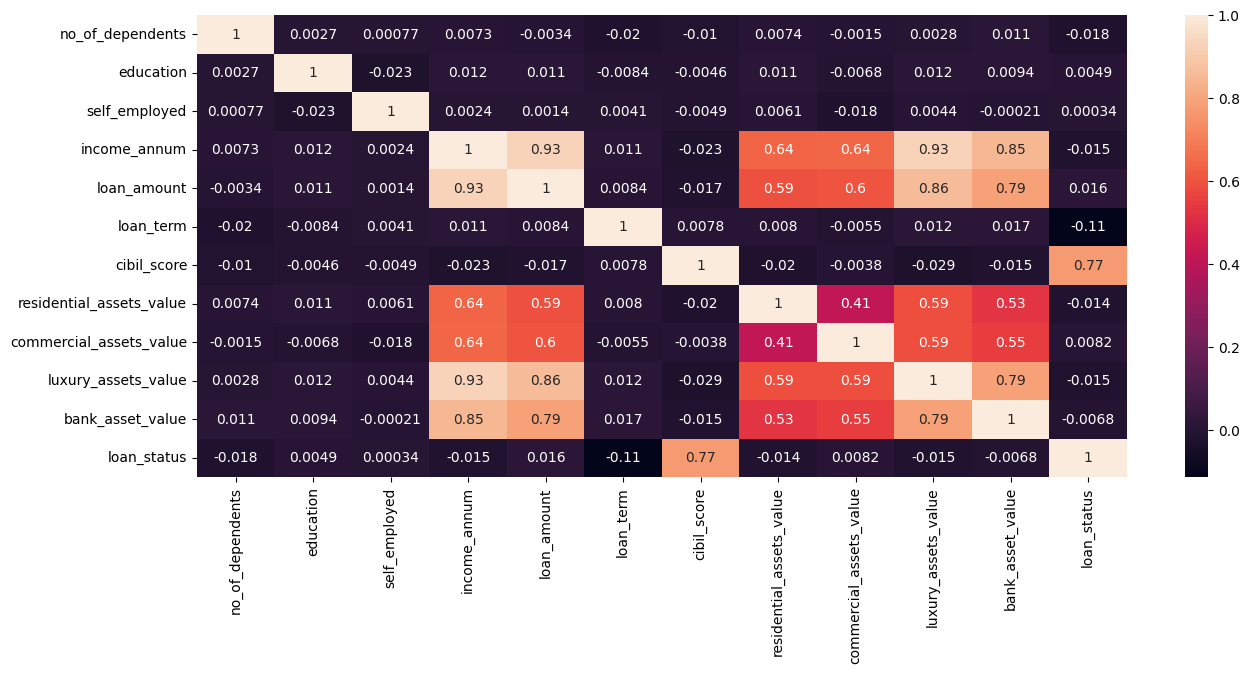

In [5]:
plt.figure(figsize = (15,6))
sns.heatmap(df.corr(), annot=True)

Prime osservazioni:


*   Il reddito annuale presenta una forte correlazione diretta con l'ammontare del prestito richiesto e i valori del bene di lusso. Inoltre non trascurabile la buona correlazione diretta anche con il valore di asset commerciali e residenziali, nonchè il valore dei beni bancari
*   La richiesta della quantià di debito rispecchia molto le correlazioni presenti nel punto precedente
*   Il valore dei beni residenziali, di lusso e commerciali presentano una non trascurabile correlazione tra essi
*   L' **approvazione del prestito** presenta un'importante correlazione con il punteggio calcolato dal **CIBIL**



<Axes: xlabel='loan_status', ylabel='count'>

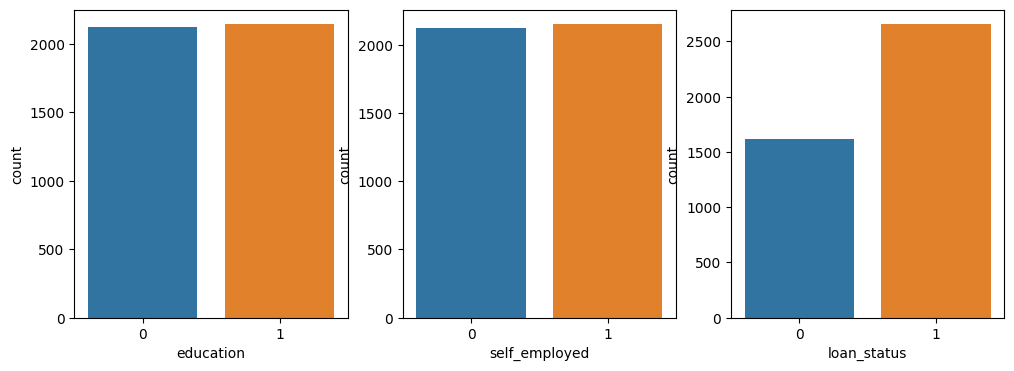

In [6]:
plt.figure(figsize = (12,4))

plt.subplot(1,3,1)
sns.countplot(x = 'education', data = df)

plt.subplot(1,3,2)
sns.countplot(x = 'self_employed', data = df)

plt.subplot(1,3,3)
sns.countplot(x = 'loan_status', data = df)


E' possibile notare come il dataframe in questione, seppur non perfettamente bilanciato sulla variabile target, non presenti gravi segni di sbilanciamento.
In seguito verrà valutato l'utilizzo dell'undersampling e dell'oversampling per migliorare le performance dei modelli di ML.

<Axes: xlabel='bank_asset_value'>

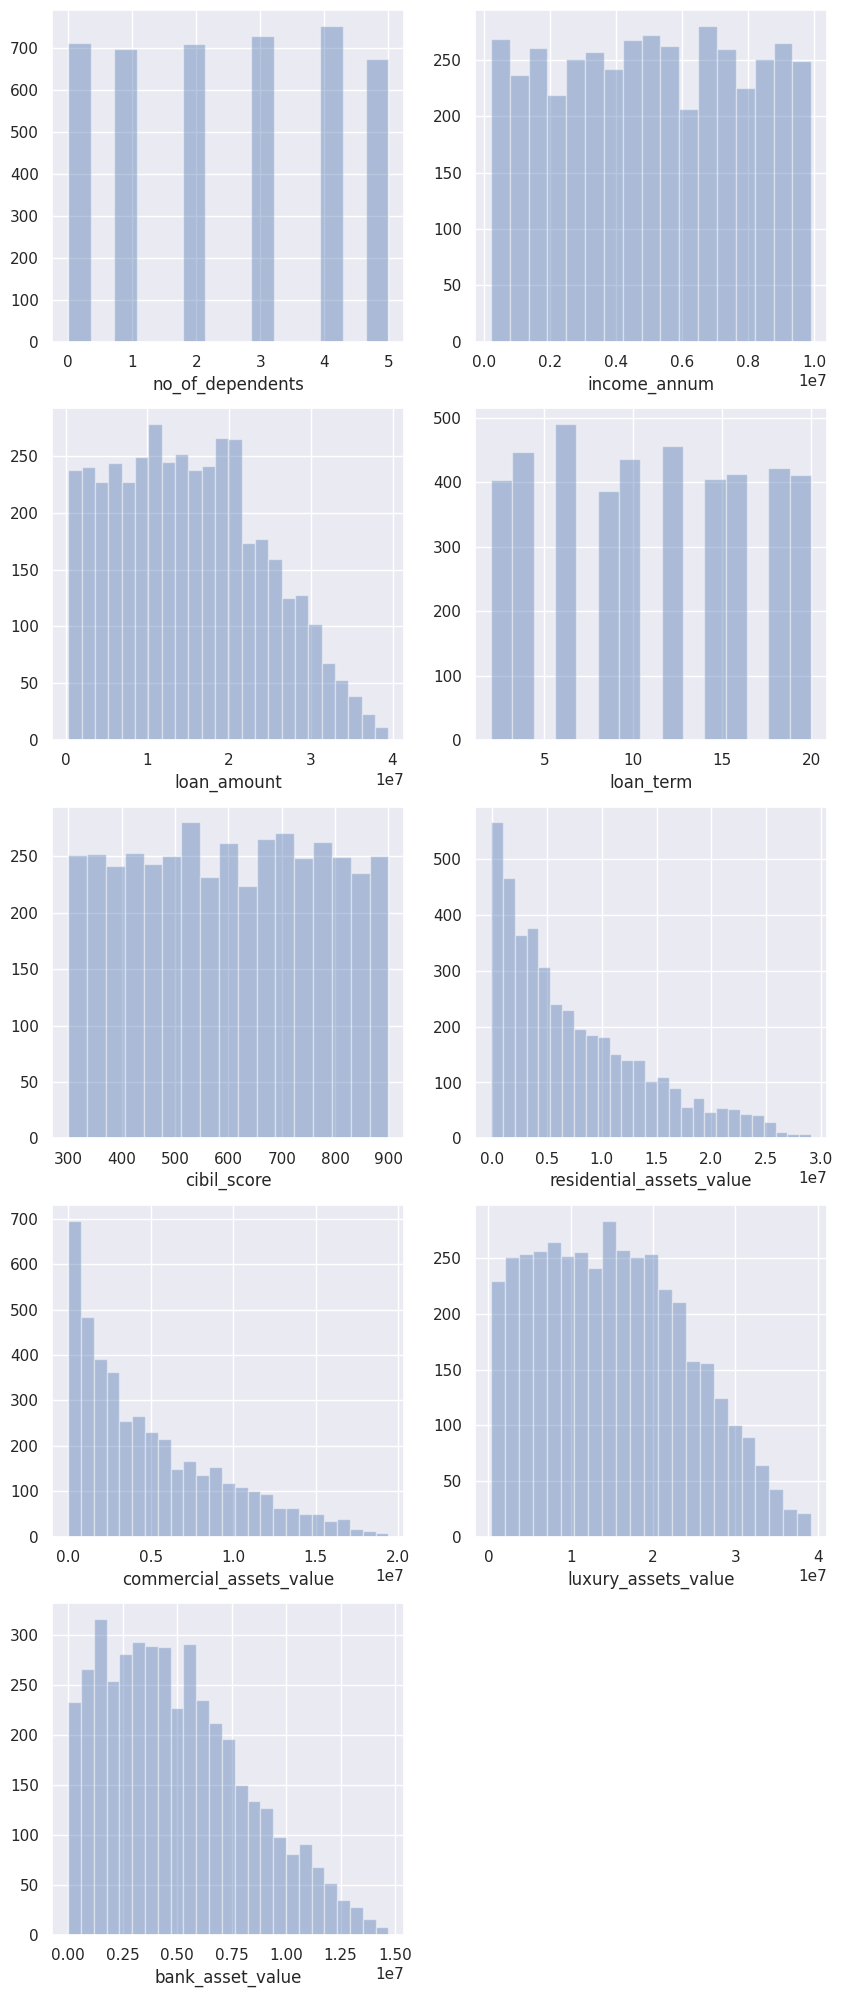

In [7]:

warnings.filterwarnings("ignore")
plt.figure(figsize = (10,25))

sns.set(color_codes = True)

plt.subplot(5,2,1)
sns.distplot(df.no_of_dependents, kde=False)

plt.subplot(5,2,2)
sns.distplot(df.income_annum, kde=False)

plt.subplot(5,2,3)
sns.distplot(df.loan_amount, kde=False)

plt.subplot(5,2,4)
sns.distplot(df.loan_term, kde=False)

plt.subplot(5,2,5)
sns.distplot(df.cibil_score, kde=False)

plt.subplot(5,2,6)
sns.distplot(df.residential_assets_value, kde=False)

plt.subplot(5,2,7)
sns.distplot(df.commercial_assets_value, kde=False)

plt.subplot(5,2,8)
sns.distplot(df.luxury_assets_value, kde=False)

plt.subplot(5,2,9)
sns.distplot(df.bank_asset_value, kde=False)

Altre osservazioni che possono essere fatte sono leseguenti:


*   Il dataframe presenta una varietà di soggetti ottimamente bilanciata per quanto riguarda il reddito annuale del richiedente.
*   Nonostante il punto precedente è possibile notare una decisa differenza nella gestione del denaro, in particolare:

  *   La richiesta di prestito presenta valori molto simili a quella del valore dei beni di lusso, questo potrebbe significare che la tendenza dei soggetti nel dataframe sia quella di comprare beni di lusso attraverso la richiesta di un mutuo
  *   E' presente un numero di soggetti decisamente elevato che non possiede o possiede in scarse quantità beni commerciali o residenziali che appunto sono una forma importante di reddito generato da investimenti

*   Una fetta molto consistente dei richiedenti di un prestito detiene un deposito di beni bancari (denaro liquido, partecipazioni in fondi comuni di risparmio/investimento, azioni, titoli di stato ecc..) piuttosto ridotto. Ciò può significare quanto segue:

  *   Un ampia circolazione di contante
  *   Gran parte del reddito viene utilizzato per spese ordinarie











### **Separazione features e target**

Si prosegue quindi con la separazione del dataframe in variabili indipendenti (features/predittori), contenuta nella lista X, e della variabile dipendente (target/etichetta), contenuta in Y.

In [8]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

## **Apprendimento supervisionato**

L'apprendimento supervisionato è uno dei principali approcci nell'ambito del machine learning, che consiste nell'addestrare un modello utilizzando un insieme di dati di addestramento etichettato.
Alcune considerazioni:


1.   Il dataframe risulta essere **sbilanciato**. In particolare lo stato dei prestiti approvati è di circa il 62% maggiore rispetto a quelli non approvati. ***Seppure non è uno sbilanciamento estremo*** si è deciso di verificare se l'applicazione di tecniche di **oversampling** e **undersampling** potesse portare migliori performance.
2.   Per ottimizzare le performance si farà utilizzo di una **Grid Search**. La Grid Search è una tecnica utilizzata per ottimizzare i parametri di un modello di machine learning. L'idea principale è di esplorare tutte le combinazioni possibili di valori dei parametri specificati in una griglia predefinita e selezionare la combinazione che offre le migliori prestazioni del modello.
3.  Al fine di ottenere una stima più affidabile delle prestazioni del modello rispetto a una singola divisione in set di addestramento e test si è deciso di usare la tecnica di **k-fold cross-validation**. L'obiettivo della k-fold cross-validation è quello di suddividere il dataset in k subset (folds) di dimensioni approssimativamente uguali. Il modello viene addestrato e valutato k volte, utilizzando k-1 folds come set di addestramento e l'ultimo fold come set di test.
4.  Si è deciso di **ottimizzare la precision** in quanto predire un errore di debito approvato quando in realtà non è così, non è più o meno aggravante del caso opposto.

Questo capitolo quindi si evolverà come segue:


*   Per ogni modello si eseguiranno i 3 seguenti casi:
    1.  Creazione modello --> applicazione della grid search per ottimizzazione parametri --> K-fold cross validation per addestramento e test --> Calcolo performance
    2.  Creazione modello --> applicazione undersampling al df --> applicazione della grid search per ottimizzazione parametri --> K-fold cross validation per addestramento e test --> Calcolo performance
    3.  Creazione modello --> applicazione oversampling al df --> applicazione della grid search per ottimizzazione parametri --> K-fold cross validation per addestramento e test --> Calcolo performance

    I modelli utilizzati sono: Knn, Random Forest e MLP

*   Discussione delle performance e conclusioni



In [9]:
# Creare un DataFrame vuoto per le performance
df_performance = pd.DataFrame()

###**KNN**

####**KNN con dataframe originale**

In [10]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23],
    'weights': ['uniform'],
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Creare il classificatore k-NN
knn_classifier = KNeighborsClassifier()

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(knn_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X, y)

# Creare il classificatore k-NN con i parametri ottimali
knn_classifier = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'], weights='uniform')

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)

print ("\n% -------------------- KNN test -------------------- %\n")

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestrare il modello k-NN sui dati di train
    knn_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = knn_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'KNN df originale',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)

print ("\n% -------------------- KNN train -------------------- %\n")

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestrare il modello k-NN sui dati di train
    knn_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = knn_classifier.predict(X_train)

    # Calcolo metriche di valutazione
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

print ("\n% -------------------------------------------------- %\n")

# Mostrare la tabella delle performance utilizzando tabulate
print(tabulate(df_performance, headers='keys', tablefmt='psql'))


Parametri ottimali: {'n_neighbors': 5, 'weights': 'uniform'}

% -------------------- KNN test -------------------- %

Average Recall: 0.7421010072350688
Average Precision: 0.6332411317252247
Average Accuracy: 0.5720316434123869
Average F1-score: 0.6832201504511843

% -------------------- KNN train -------------------- %

Average Recall: 0.8502760526311185
Average Precision: 0.7348502728913402
Average Accuracy: 0.7159625057044434
Average F1-score: 0.788352084681089

% -------------------------------------------------- %

+----+------------------+----------+-------------+------------+------------+
|    | Modello          |   Recall |   Precision |   Accuracy |   F1-score |
|----+------------------+----------+-------------+------------+------------|
|  0 | KNN df originale | 0.742101 |    0.633241 |   0.572032 |    0.68322 |
+----+------------------+----------+-------------+------------+------------+


##### **Discussione risultati KNN con dataset originale**

E' possibile notare un **grande differenza tra gli score** delle performance generati dalla valutazione del modello **sui dati di train** e quelli generati **sui dati di test**. Questo è un segno di **overfitting** perciò nei passi seguenti si approfondirà e cercherà di risolvere questa questione.

Si procede quindi con il calcolo e la conseguente stampa della curva **precison vs n_neighbors**, per capire come influisce la variazione del numero dei vicini sullo score della precision

In [11]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23],
    'weights': ['uniform', 'distance'],
}

max_n_neighbors = np.arange(1, 23, 2)
precisions = []

# Ottenere i migliori parametri dalla grid search
best_params = grid_search.best_params_
best_n_neighbors = best_params['n_neighbors']
best_weights = best_params['weights']


# Crea il classificatore KNN con i parametri variabili
for num_neighbors in max_n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=num_neighbors, weights=best_weights)
    clf.fit(X, y)
    y_pred_clf = clf.predict(X)
    precision_clf = precision_score(y, y_pred_clf)
    precisions.append(precision_clf)

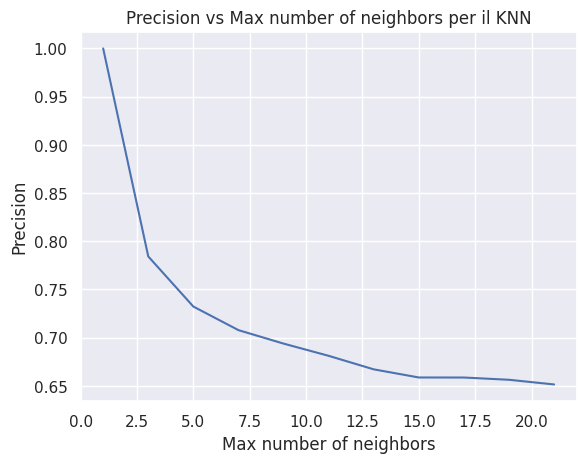

In [12]:
plt.plot(max_n_neighbors, precisions)
plt.xlabel("Max number of neighbors")
plt.ylabel("Precision")
plt.title("Precision vs Max number of neighbors per il KNN")
plt.show()

Dal grafico è possibile osservare che al diminuire del numero di vicini aumenta lo score della precision in modo parabolico. Questo grafico mostra come un **KNN con K=1 andrebbe facilmente in overfitting** in quanto l'adattamento ai dati di train sarebbe estremo.
Nel nostro caso invece la Grid Search ha scelto 5 come valore dell'iperparametro "n_neighbors", portando sicuramente a diminuire il grado di overfitting ma non abbastanza.
Si procede perciò con un **aumento del numero di vicini** che dovrebbe portare ad una **riduzione dell'overfitting**, quindi **performance probabilmente minori** ma sicuramente **più veritiere**. Si sceglie quindi come numero di vicini 15.

###### Valutazione presenza overfitting con n_neighbors = 15

In [13]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare il classificatore k-NN con i parametri ottimali
knn_classifier = KNeighborsClassifier(n_neighbors=15, weights='uniform')

# Visualizzare i parametri attuali
print("Parametri attuali: n_neighbors = 15, weights = uniform")

print ("\n% -------------------- KNN test -------------------- %\n")

# Effettuare la k-fold cross-validation con sampling
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestrare il modello k-NN sui dati di train
    knn_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = knn_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'KNN df originale',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

print ("\n% -------------------- KNN train -------------------- %\n")

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Effettuare la k-fold cross-validation con sampling
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestrare il modello k-NN sui dati di train
    knn_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = knn_classifier.predict(X_train)

    # Calcolo metriche di valutazione
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

print ("\n% -------------------------------------------------- %\n")

# Mostrare la tabella delle performance utilizzando tabulate
print("Performance del modello con parametri della Grid Search")
print(tabulate(df_performance, headers='keys', tablefmt='psql'))

# Aggiorna le performance nel DataFrame
df_performance.loc[df_performance['Modello'] == 'KNN df originale', ['Recall', 'Precision', 'Accuracy', 'F1-score']] = [model_performance['Recall'], model_performance['Precision'], model_performance['Accuracy'], model_performance['F1-score']]

# Mostrare la tabella delle performance utilizzando tabulate
print("\nPerformance del modello con parametri aggiornati")
print(tabulate(df_performance, headers='keys', tablefmt='psql'))

Parametri attuali: n_neighbors = 15, weights = uniform

% -------------------- KNN test -------------------- %

Average Recall: 0.8497715988083417
Average Precision: 0.6259247591519297
Average Accuracy: 0.5905438093039107
Average F1-score: 0.7208112334083522

% -------------------- KNN train -------------------- %

Average Recall: 0.887591928588553
Average Precision: 0.6621228762361053
Average Accuracy: 0.6482653751088907
Average F1-score: 0.7584530055658758

% -------------------------------------------------- %

Performance del modello con parametri della Grid Search
+----+------------------+----------+-------------+------------+------------+
|    | Modello          |   Recall |   Precision |   Accuracy |   F1-score |
|----+------------------+----------+-------------+------------+------------|
|  0 | KNN df originale | 0.742101 |    0.633241 |   0.572032 |    0.68322 |
+----+------------------+----------+-------------+------------+------------+

Performance del modello con parametri 

Come ipotizzato, e' possibile notare una **minor differenza tra gli score** delle performance generati dalla valutazione del modello **sui dati di train** e quelli generati **sui dati di test**, rispetto al caso precedente.

Questo indica una **netta riduzione di adattamento del modello ai dati**. Da notare che **non può esserci un'assenza di differenza tra questi valori** in quanto è logico che testare un modello sui dati su cui esso stesso è stato addestrato porterà sempre a performance migliori, l'obiettivo è appunto cercare di minimizzare questo gap.

Va inoltre notato che in linea generale **le performance calcolate sui dati di test sono** addirittura **migliorate rispetto al caso precedente**, questo ad ulteriore testimonianza di un minore adattamento ai dati di addestramento.

Possiamo quindi concludere che **il modello attualmente non presenta overfitting o questo è in una forma leggera**.


####**KNN con undersampling del dataframe**

In [14]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23],
    'weights': ['uniform'],
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Applica l'undersampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Creare il classificatore k-NN
knn_classifier = KNeighborsClassifier()

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(knn_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X_resampled, y_resampled)

# Creare il classificatore k-NN con i parametri ottimali
knn_classifier = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'], weights='uniform')

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)

print ("\n% -------------------- KNN test -------------------- %\n")

# Effettuare la k-fold cross-validation con sampling
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Addestrare il modello k-NN sui dati di train
    knn_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = knn_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'KNN df undersampled',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)

print ("\n% -------------------- KNN train -------------------- %\n")

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Effettuare la k-fold cross-validation con sampling
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Addestrare il modello k-NN sui dati di train
    knn_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = knn_classifier.predict(X_train)

    # Calcolo metriche di valutazione
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

print ("\n% -------------------------------------------------- %\n")

# Mostrare la tabella delle performance utilizzando tabulate
print(tabulate([df_performance.iloc[1]], headers='keys', tablefmt='psql'))


Parametri ottimali: {'n_neighbors': 3, 'weights': 'uniform'}

% -------------------- KNN test -------------------- %

Average Recall: 0.5387393604784909
Average Precision: 0.5248673536154032
Average Accuracy: 0.5250889371767012
Average F1-score: 0.5312598767565275

% -------------------- KNN train -------------------- %

Average Recall: 0.7752984547561955
Average Precision: 0.7515043351998946
Average Accuracy: 0.7594542052536134
Average F1-score: 0.7632025359715132

% -------------------------------------------------- %

+---------------------+----------+-------------+------------+------------+
| Modello             |   Recall |   Precision |   Accuracy |   F1-score |
|---------------------+----------+-------------+------------+------------|
| KNN df undersampled | 0.538739 |    0.524867 |   0.525089 |    0.53126 |
+---------------------+----------+-------------+------------+------------+


##### **Discussione risultati KNN con dataset undersampled**

E' possibile notare un **grande differenza tra gli score** delle performance generati dalla valutazione del modello **sui dati di train** e quelli generati **sui dati di test**. Questo è un segno di **overfitting** perciò nei passi seguenti si approfondirà e cercherà di risolvere questa questione.

Si procede quindi con il calcolo e la conseguente stampa della curva **precison vs n_neighbors**, per capire come influisce la variazione del numero dei vicini sullo score della precision

In [15]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23],
    'weights': ['uniform', 'distance'],
}

max_n_neighbors = np.arange(1, 23, 2)
precisions = []

# Ottenere i migliori parametri dalla grid search
best_params = grid_search.best_params_
best_n_neighbors = best_params['n_neighbors']
best_weights = best_params['weights']


# Crea il classificatore KNN con i parametri variabili
for num_neighbors in max_n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=num_neighbors, weights=best_weights)
    clf.fit(X_resampled, y_resampled)
    y_pred_clf = clf.predict(X_resampled)
    precision_clf = precision_score(y_resampled, y_pred_clf)
    precisions.append(precision_clf)

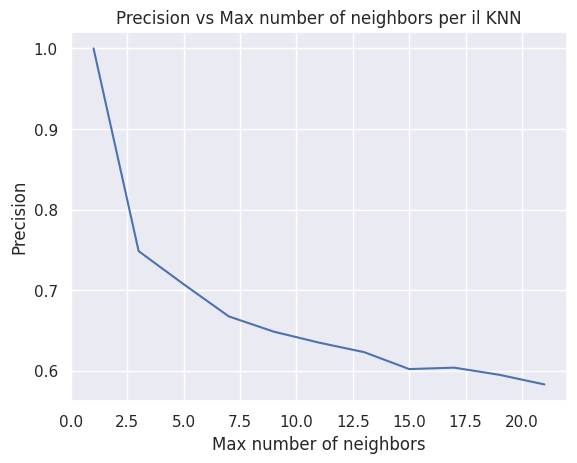

In [16]:
plt.plot(max_n_neighbors, precisions)
plt.xlabel("Max number of neighbors")
plt.ylabel("Precision")
plt.title("Precision vs Max number of neighbors per il KNN")
plt.show()

Dal grafico è possibile osservare che al diminuire del numero di vicini aumenta lo score della precision in modo parabolico. Questo grafico mostra come un **KNN con K=1 andrebbe facilmente in overfitting** in quanto l'adattamento ai dati di train sarebbe estremo.
Nel nostro caso invece la Grid Search ha scelto 3 come valore dell'iperparametro "n_neighbors", portando sicuramente a diminuire il grado di overfitting ma non abbastanza.
Si procede perciò con un **aumento del numero di vicini** che dovrebbe portare ad una **riduzione dell'overfitting**, quindi **performance probabilmente minori** ma sicuramente **più veritiere**. Si sceglie quindi come numero di vicini 15.

###### Valutazione presenza overfitting con n_neighbors = 15

In [17]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare il classificatore k-NN con i parametri ottimali
knn_classifier = KNeighborsClassifier(n_neighbors=15, weights='uniform')

# Visualizzare i parametri attuali
print("Parametri attuali: n_neighbors = 15, weights = uniform")

print ("\n% -------------------- KNN test -------------------- %\n")

# Effettuare la k-fold cross-validation con sampling
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Addestrare il modello k-NN sui dati di train
    knn_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = knn_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'KNN df undersampled',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

print ("\n% -------------------- KNN train -------------------- %\n")

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Effettuare la k-fold cross-validation con sampling
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Addestrare il modello k-NN sui dati di train
    knn_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = knn_classifier.predict(X_train)

    # Calcolo metriche di valutazione
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

print ("\n% -------------------------------------------------- %\n")

# Mostrare la tabella delle performance utilizzando tabulate
print("Performance del modello con parametri della Grid Search")
print(tabulate([df_performance.iloc[1]], headers='keys', tablefmt='psql'))

# Aggiorna le performance nel DataFrame
df_performance.loc[df_performance['Modello'] == 'KNN df undersampled', ['Recall', 'Precision', 'Accuracy', 'F1-score']] = [model_performance['Recall'], model_performance['Precision'], model_performance['Accuracy'], model_performance['F1-score']]

# Mostrare la tabella delle performance utilizzando tabulate
print("\nPerformance del modello con parametri aggiornati")
print(tabulate([df_performance.iloc[1]], headers='keys', tablefmt='psql'))

Parametri attuali: n_neighbors = 15, weights = uniform

% -------------------- KNN test -------------------- %

Average Recall: 0.5387853692201519
Average Precision: 0.5110695040126156
Average Accuracy: 0.5120762263715555
Average F1-score: 0.5242378904210971

% -------------------- KNN train -------------------- %

Average Recall: 0.640213171119756
Average Precision: 0.6080992943287485
Average Accuracy: 0.613762776514084
Average F1-score: 0.6237084750758872

% -------------------------------------------------- %

Performance del modello con parametri della Grid Search
+---------------------+----------+-------------+------------+------------+
| Modello             |   Recall |   Precision |   Accuracy |   F1-score |
|---------------------+----------+-------------+------------+------------|
| KNN df undersampled | 0.538739 |    0.524867 |   0.525089 |    0.53126 |
+---------------------+----------+-------------+------------+------------+

Performance del modello con parametri aggiornati


Come ipotizzato, e' possibile notare una **minor differenza tra gli score** delle performance generati dalla valutazione del modello **sui dati di train** e quelli generati **sui dati di test**, rispetto al caso precedente.

Questo indica una **netta riduzione di adattamento del modello ai dati**. Da notare che **non può esserci un'assenza di differenza tra questi valori** in quanto è logico che testare un modello sui dati su cui esso stesso è stato addestrato porterà sempre a performance migliori, l'obiettivo è appunto cercare di minimizzare questo gap.

Va inoltre notato che in linea generale **le performance calcolate sui dati di test sono rimaste pressochè inveriate rispetto al caso precedente**, questo può significare che una riduzione del dataset al fine del ribilanciamento della classe minoritaria non ha portato all'ottenimento dei risultati sperati.

Possiamo quindi concludere che **il modello attualmente presenta una forma leggera di overfitting e restituisce performance peggiori rispetto al modello precedente**.


####**KNN con oversampling del dataframe**

In [18]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23],
    'weights': ['uniform'],
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Applica l'oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Creare il classificatore k-NN
knn_classifier = KNeighborsClassifier()

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(knn_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X_resampled, y_resampled)

# Creare il classificatore k-NN con i parametri ottimali
knn_classifier = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'], weights='uniform')

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)

print ("\n% -------------------- KNN test -------------------- %\n")

# Effettuare la k-fold cross-validation con sampling
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Addestrare il modello k-NN sui dati di train
    knn_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = knn_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'KNN df oversampled',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)

print ("\n% -------------------- KNN train -------------------- %\n")

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Effettuare la k-fold cross-validation con sampling
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Addestrare il modello k-NN sui dati di train
    knn_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = knn_classifier.predict(X_train)

    # Calcolo metriche di valutazione
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

print ("\n% -------------------------------------------------- %\n")

# Mostrare la tabella delle performance utilizzando tabulate
print(tabulate([df_performance.iloc[2]], headers='keys', tablefmt='psql'))


Parametri ottimali: {'n_neighbors': 1, 'weights': 'uniform'}

% -------------------- KNN test -------------------- %

Average Recall: 0.610693715420627
Average Precision: 0.731559508942694
Average Accuracy: 0.6927817424918228
Average F1-score: 0.6654070400089864

% -------------------- KNN train -------------------- %

Average Recall: 1.0
Average Precision: 1.0
Average Accuracy: 1.0
Average F1-score: 1.0

% -------------------------------------------------- %

+--------------------+----------+-------------+------------+------------+
| Modello            |   Recall |   Precision |   Accuracy |   F1-score |
|--------------------+----------+-------------+------------+------------|
| KNN df oversampled | 0.610694 |     0.73156 |   0.692782 |   0.665407 |
+--------------------+----------+-------------+------------+------------+


##### **Discussione risultati KNN con dataset oversampled**

E' possibile notare un **grande differenza tra gli score** delle performance generati dalla valutazione del modello **sui dati di train** e quelli generati **sui dati di test**. Inoltre **l'ottenimento di performance perfette è un campanello d'allarme**. Questo è un segno di **overfitting** perciò nei passi seguenti si approfondirà e cercherà di risolvere questa questione.

Si procede quindi con il calcolo e la conseguente stampa della curva **precison vs n_neighbors**, per capire come influisce la variazione del numero dei vicini sullo score della precision

In [19]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23],
    'weights': ['uniform', 'distance'],
}

max_n_neighbors = np.arange(1, 23, 2)
precisions = []

# Ottenere i migliori parametri dalla grid search
best_params = grid_search.best_params_
best_n_neighbors = best_params['n_neighbors']
best_weights = best_params['weights']


# Crea il classificatore KNN con i parametri variabili
for num_neighbors in max_n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=num_neighbors, weights=best_weights)
    clf.fit(X_resampled, y_resampled)
    y_pred_clf = clf.predict(X_resampled)
    precision_clf = precision_score(y_resampled, y_pred_clf)
    precisions.append(precision_clf)

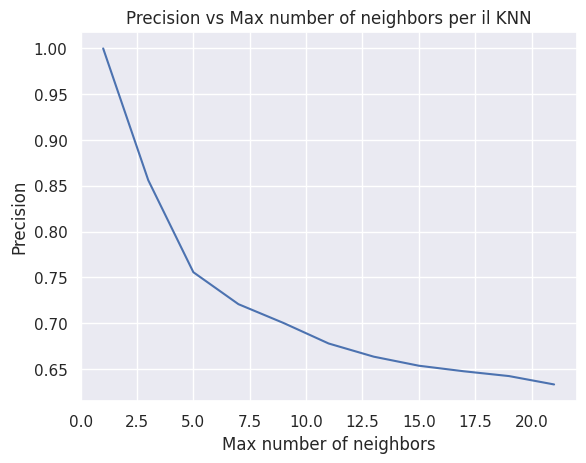

In [20]:
plt.plot(max_n_neighbors, precisions)
plt.xlabel("Max number of neighbors")
plt.ylabel("Precision")
plt.title("Precision vs Max number of neighbors per il KNN")
plt.show()

Dal grafico è possibile osservare che al diminuire del numero di vicini aumenta lo score della precision in modo parabolico. Questo grafico mostra come un **KNN con K=1 andrebbe facilmente in overfitting** in quanto l'adattamento ai dati di train sarebbe estremo.
Nel nostro caso invece la Grid Search ha scelto 5 come valore dell'iperparametro "n_neighbors", portando sicuramente a diminuire il grado di overfitting ma non abbastanza.
Si procede perciò con un **aumento del numero di vicini** che dovrebbe portare ad una **riduzione dell'overfitting**, quindi **performance probabilmente minori** ma sicuramente **più veritiere**. Si sceglie quindi come numero di vicini 15.

###### Valutazione presenza overfitting con n_neighbors = 15

In [21]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare il classificatore k-NN con i parametri ottimali
knn_classifier = KNeighborsClassifier(n_neighbors=15, weights='uniform')

# Visualizzare i parametri attuali
print("Parametri attuali: n_neighbors = 15, weights = uniform")

print ("\n% -------------------- KNN test -------------------- %\n")

# Effettuare la k-fold cross-validation con sampling
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Addestrare il modello k-NN sui dati di train
    knn_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = knn_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'KNN df oversampled',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

print ("\n% -------------------- KNN train -------------------- %\n")

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Effettuare la k-fold cross-validation con sampling
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Addestrare il modello k-NN sui dati di train
    knn_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = knn_classifier.predict(X_train)

    # Calcolo metriche di valutazione
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

print ("\n% -------------------------------------------------- %\n")

# Mostrare la tabella delle performance utilizzando tabulate
print("Performance del modello con parametri della Grid Search")
print(tabulate([df_performance.iloc[2]], headers='keys', tablefmt='psql'))

# Aggiorna le performance nel DataFrame
df_performance.loc[df_performance['Modello'] == 'KNN df oversampled', ['Recall', 'Precision', 'Accuracy', 'F1-score']] = [model_performance['Recall'], model_performance['Precision'], model_performance['Accuracy'], model_performance['F1-score']]

# Mostrare la tabella delle performance utilizzando tabulate
print("\nPerformance del modello con parametri aggiornati")
print(tabulate([df_performance.iloc[2]], headers='keys', tablefmt='psql'))

Parametri attuali: n_neighbors = 15, weights = uniform

% -------------------- KNN test -------------------- %

Average Recall: 0.5493275641935026
Average Precision: 0.5744791096768073
Average Accuracy: 0.5705977514407488
Average F1-score: 0.5612086388360702

% -------------------- KNN train -------------------- %

Average Recall: 0.6198540727169004
Average Precision: 0.6516708040802128
Average Accuracy: 0.6442645137350688
Average F1-score: 0.6353488506331233

% -------------------------------------------------- %

Performance del modello con parametri della Grid Search
+--------------------+----------+-------------+------------+------------+
| Modello            |   Recall |   Precision |   Accuracy |   F1-score |
|--------------------+----------+-------------+------------+------------|
| KNN df oversampled | 0.610694 |     0.73156 |   0.692782 |   0.665407 |
+--------------------+----------+-------------+------------+------------+

Performance del modello con parametri aggiornati
+--

Come ipotizzato, e' possibile notare una **minor differenza tra gli score** delle performance generati dalla valutazione del modello **sui dati di train** e quelli generati **sui dati di test**, rispetto al caso precedente.

Questo indica una **netta riduzione di adattamento del modello ai dati**. Da notare che **non può esserci un'assenza di differenza tra questi valori** in quanto è logico che testare un modello sui dati su cui esso stesso è stato addestrato porterà sempre a performance migliori, l'obiettivo è appunto cercare di minimizzare questo gap.

Va inoltre notato che in linea generale **le performance calcolate sui dati di test sono rimaste pressochè invariate rispetto al caso precedente**, questo può significare che un aumento del dataset al fine del ribilanciamento della classe minoritaria non ha portato all'ottenimento dei risultati sperati.

Possiamo quindi concludere che **il modello attualmente presenta una forma leggera di overfitting e restituisce performance peggiori rispetto al modello che utilizza il dataset originale**.


In [22]:
# Mostrare la tabella delle performance utilizzando tabulate
print("\nPerformance dei modelli Random Forest con parametri aggiornati")
print(tabulate(df_performance.iloc[0:3].to_dict(orient='records'), headers='keys', tablefmt='psql'))


Performance dei modelli Random Forest con parametri aggiornati
+---------------------+----------+-------------+------------+------------+
| Modello             |   Recall |   Precision |   Accuracy |   F1-score |
|---------------------+----------+-------------+------------+------------|
| KNN df originale    | 0.849772 |    0.625925 |   0.590544 |   0.720811 |
| KNN df undersampled | 0.538785 |    0.51107  |   0.512076 |   0.524238 |
| KNN df oversampled  | 0.549328 |    0.574479 |   0.570598 |   0.561209 |
+---------------------+----------+-------------+------------+------------+


###**Random Forest**

####**Random forest con dataframe originale**

In [23]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Creare il classificatore Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X, y)

# Creare il classificatore RF con i parametri ottimali
rf_classifier = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'], max_depth=grid_search.best_params_['max_depth'], min_samples_split=grid_search.best_params_['min_samples_split'], min_samples_leaf=grid_search.best_params_['min_samples_leaf'], random_state=42)

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)

print ("\n% -------------------- RF test -------------------- %\n")

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestrare il modello RF sui dati di train
    rf_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = rf_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'RF df originale',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)

print ("\n% -------------------- RF train -------------------- %\n")

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestrare il modello RF sui dati di train
    rf_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = rf_classifier.predict(X_train)

    # Calcolo metriche di valutazione
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

print ("\n% -------------------------------------------------- %\n")

# Mostrare la tabella delle performance utilizzando tabulate
print(tabulate([df_performance.iloc[3]], headers='keys', tablefmt='psql'))


Parametri ottimali: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}

% -------------------- RF test -------------------- %

Average Recall: 0.9529365867498936
Average Precision: 0.993016738339826
Average Accuracy: 0.9665000934569165
Average F1-score: 0.9724786432283716

% -------------------- RF train -------------------- %

Average Recall: 0.9624329380224657
Average Precision: 0.9940404138480703
Average Accuracy: 0.9730354398154638
Average F1-score: 0.9779665145377375

% -------------------------------------------------- %

+-----------------+----------+-------------+------------+------------+
| Modello         |   Recall |   Precision |   Accuracy |   F1-score |
|-----------------+----------+-------------+------------+------------|
| RF df originale | 0.952937 |    0.993017 |     0.9665 |   0.972479 |
+-----------------+----------+-------------+------------+------------+


##### **Discussione risultati RF con dataset originale**

E' possibile notare una **lieve, e trascurabile, differenza tra gli score** delle performance generati dalla valutazione del modello **sui dati di train** e quelli generati **sui dati di test**. Questo è un segno di assenza di **overfitting** perciò nei passi seguenti si approfondirà tale tesi.

Si procede quindi con il calcolo e la conseguente stampa della curva **precison vs max depth**, per capire come influisce la variazione della profondità degli alberi sullo score della precision

In [24]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

max_depths = np.arange(3, 10)
precisions = []

# Ottenere i migliori parametri dalla grid search
best_params = grid_search.best_params_
best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']


# Crea il classificatore RF con i parametri variabili
for max_depth in max_depths:
    clf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=max_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, random_state=42)
    clf.fit(X, y)
    y_pred_clf = clf.predict(X)
    precision_clf = precision_score(y, y_pred_clf)
    precisions.append(precision_clf)

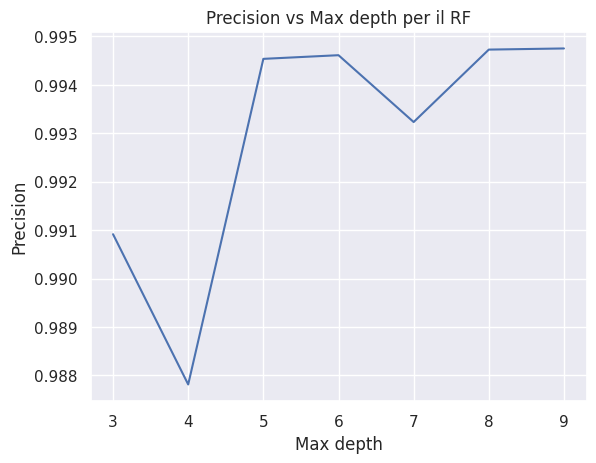

In [25]:
plt.plot(max_depths, precisions)
plt.xlabel("Max depth")
plt.ylabel("Precision")
plt.title("Precision vs Max depth per il RF")
plt.show()

Dal grafico è possibile osservare che al variare della profondità degli alberi nel random forest non segue una particolazre variazione dello score della precision.
Ciò potrebbe indicare che **la situazione potrebbe rimanere pressochè simile a quella attuale anche in un modello più complesso**, **ovvero una assenza di overfitting**.

Per verificare ciò aumentiamo il valore di profondità a 9.

###### Valutazione presenza overfitting con depth = 9

In [26]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Creare il classificatore RF con i parametri ottimali
rf_classifier = RandomForestClassifier(n_estimators = grid_search.best_params_['n_estimators'], max_depth= 9, min_samples_split=grid_search.best_params_['min_samples_split'], min_samples_leaf=grid_search.best_params_['min_samples_leaf'], random_state=42)

# Visualizzare i parametri ottimali
print("Parametri attuali : max_depth = 9, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 50, ")

print ("\n% -------------------- RF test -------------------- %\n")

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestrare il modello RF sui dati di train
    rf_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = rf_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'RF df originale',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

print ("\n% -------------------- RF train -------------------- %\n")

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestrare il modello RF sui dati di train
    rf_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = rf_classifier.predict(X_train)

    # Calcolo metriche di valutazione
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

print ("\n% -------------------------------------------------- %\n")

# Mostrare la tabella delle performance utilizzando tabulate
print("Performance del modello con parametri della Grid Search")
print(tabulate([df_performance.iloc[3]], headers='keys', tablefmt='psql'))

# Aggiorna le performance nel DataFrame
df_performance.loc[df_performance['Modello'] == 'RF df originale', ['Recall', 'Precision', 'Accuracy', 'F1-score']] = [model_performance['Recall'], model_performance['Precision'], model_performance['Accuracy'], model_performance['F1-score']]

# Mostrare la tabella delle performance utilizzando tabulate
print("\nPerformance del modello con parametri aggiornati")
print(tabulate([df_performance.iloc[3]], headers='keys', tablefmt='psql'))


Parametri attuali : max_depth = 9, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 50, 

% -------------------- RF test -------------------- %

Average Recall: 0.9841835721378919
Average Precision: 0.9810779329597817
Average Accuracy: 0.9782129938098537
Average F1-score: 0.9825549046678074

% -------------------- RF train -------------------- %

Average Recall: 0.9991214964065034
Average Precision: 0.9950431154285706
Average Accuracy: 0.9963561729155128
Average F1-score: 0.9970776959881604

% -------------------------------------------------- %

Performance del modello con parametri della Grid Search
+-----------------+----------+-------------+------------+------------+
| Modello         |   Recall |   Precision |   Accuracy |   F1-score |
|-----------------+----------+-------------+------------+------------|
| RF df originale | 0.952937 |    0.993017 |     0.9665 |   0.972479 |
+-----------------+----------+-------------+------------+------------+

Performance del modello 

Come ipotizzato, e' possibile notare una **minimo aumento della differenza tra gli score** delle performance generati dalla valutazione del modello **sui dati di train** e quelli generati **sui dati di test**, rispetto al caso precedente.

Questo indica un **lieve aumento di adattamento del modello ai dati**. Da notare che **non può esserci un'assenza di differenza tra questi valori** in quanto è logico che testare un modello sui dati su cui esso stesso è stato addestrato porterà sempre a performance migliori, l'obiettivo è appunto cercare di minimizzare questo gap.

Possiamo quindi concludere che **il modello attualmente non presenta overfitting o questo è in una forma così lieve da essere tracurabile**.

**Le performance risultano essere leggermente migliorate nel complesso.**


####**Random forest con undersampling del dataframe**

In [27]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Creare il classificatore Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Applica l'undersampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X_resampled, y_resampled)

# Creare il classificatore RF con i parametri ottimali
rf_classifier = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'], max_depth=grid_search.best_params_['max_depth'], min_samples_split=grid_search.best_params_['min_samples_split'], min_samples_leaf=grid_search.best_params_['min_samples_leaf'], random_state=42)

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)

print ("\n% -------------------- RF test -------------------- %\n")

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestrare il modello RF sui dati di train
    rf_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = rf_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'RF df undersampled',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)

print ("\n% -------------------- RF train -------------------- %\n")

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestrare il modello RF sui dati di train
    rf_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = rf_classifier.predict(X_train)

    # Calcolo metriche di valutazione
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

print ("\n% -------------------------------------------------- %\n")

# Mostrare la tabella delle performance utilizzando tabulate
print(tabulate([df_performance.iloc[4]], headers='keys', tablefmt='psql'))

Parametri ottimali: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

% -------------------- RF test -------------------- %

Average Recall: 0.952861938058911
Average Precision: 0.9916904381598423
Average Accuracy: 0.9658990827452263
Average F1-score: 0.97182174043494

% -------------------- RF train -------------------- %

Average Recall: 0.9608766734152938
Average Precision: 0.9943409649157516
Average Accuracy: 0.9724805796036968
Average F1-score: 0.9773194219335186

% -------------------------------------------------- %

+--------------------+----------+-------------+------------+------------+
| Modello            |   Recall |   Precision |   Accuracy |   F1-score |
|--------------------+----------+-------------+------------+------------|
| RF df undersampled | 0.952862 |     0.99169 |   0.965899 |   0.971822 |
+--------------------+----------+-------------+------------+------------+


##### Discussione risultati Random Forest con dataset undersampled

E' possibile notare una **lieve, e trascurabile, differenza tra gli score** delle performance generati dalla valutazione del modello **sui dati di train** e quelli generati **sui dati di test**. Questo è un segno di assenza di **overfitting** perciò nei passi seguenti si approfondirà tale tesi.

Si procede quindi con il calcolo e la conseguente stampa della curva **precison vs max depth**, per capire come influisce la variazione della profondità degli alberi sullo score della precision

In [28]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

max_depths = np.arange(3, 10)
precisions = []

# Ottenere i migliori parametri dalla grid search
best_params = grid_search.best_params_
best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']


# Crea il classificatore RF con i parametri variabili
for max_depth in max_depths:
    clf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=max_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, random_state=42)
    clf.fit(X_resampled, y_resampled)
    y_pred_clf = clf.predict(X_resampled)
    precision_clf = precision_score(y_resampled, y_pred_clf)
    precisions.append(precision_clf)

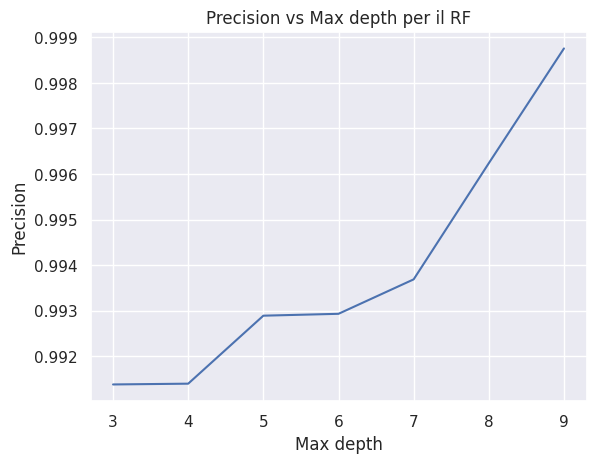

In [29]:
plt.plot(max_depths, precisions)
plt.xlabel("Max depth")
plt.ylabel("Precision")
plt.title("Precision vs Max depth per il RF")
plt.show()

Dal grafico è possibile osservare che al variare della profondità degli alberi nel random forest non segue una particolazre variazione dello score della precision.
Ciò potrebbe indicare che **la situazione potrebbe rimanere pressochè simile a quella attuale anche in un modello più complesso**, **ovvero una assenza di overfitting**.

Per verificare ciò aumentiamo il valore di profondità a 9.

##### Valutazione presenza overfitting con depth = 9

In [30]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Creare il classificatore RF con i parametri ottimali
rf_classifier = RandomForestClassifier(n_estimators = grid_search.best_params_['n_estimators'], max_depth= 9, min_samples_split=grid_search.best_params_['min_samples_split'], min_samples_leaf=grid_search.best_params_['min_samples_leaf'], random_state=42)

# Visualizzare i parametri ottimali
print("Parametri attuali : max_depth = 9, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 50, ")

print ("\n% -------------------- RF test -------------------- %\n")

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestrare il modello RF sui dati di train
    rf_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = rf_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'RF df undersampled',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

print ("\n% -------------------- RF train -------------------- %\n")

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestrare il modello RF sui dati di train
    rf_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = rf_classifier.predict(X_train)

    # Calcolo metriche di valutazione
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

print ("\n% -------------------------------------------------- %\n")

# Mostrare la tabella delle performance utilizzando tabulate
print("Performance del modello con parametri della Grid Search")
print(tabulate([df_performance.iloc[4]], headers='keys', tablefmt='psql'))

# Aggiorna le performance nel DataFrame
df_performance.loc[df_performance['Modello'] == 'RF df undersampled', ['Recall', 'Precision', 'Accuracy', 'F1-score']] = [model_performance['Recall'], model_performance['Precision'], model_performance['Accuracy'], model_performance['F1-score']]

# Mostrare la tabella delle performance utilizzando tabulate
print("\nPerformance del modello con parametri aggiornati")
print(tabulate([df_performance.iloc[4]], headers='keys', tablefmt='psql'))


Parametri attuali : max_depth = 9, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 50, 

% -------------------- RF test -------------------- %

Average Recall: 0.979007553441767
Average Precision: 0.9843850670454044
Average Accuracy: 0.9773676518662384
Average F1-score: 0.981650278548319

% -------------------- RF train -------------------- %

Average Recall: 0.9991083086777502
Average Precision: 0.9990513548471494
Average Accuracy: 0.9988633991244928
Average F1-score: 0.9990795608687504

% -------------------------------------------------- %

Performance del modello con parametri della Grid Search
+--------------------+----------+-------------+------------+------------+
| Modello            |   Recall |   Precision |   Accuracy |   F1-score |
|--------------------+----------+-------------+------------+------------|
| RF df undersampled | 0.952862 |     0.99169 |   0.965899 |   0.971822 |
+--------------------+----------+-------------+------------+------------+

Performance

Come ipotizzato, e' possibile notare una **minimo aumento della differenza tra gli score** delle performance generati dalla valutazione del modello **sui dati di train** e quelli generati **sui dati di test**, rispetto al caso precedente.

Questo indica un **lieve aumento di adattamento del modello ai dati**. Da notare che **non può esserci un'assenza di differenza tra questi valori** in quanto è logico che testare un modello sui dati su cui esso stesso è stato addestrato porterà sempre a performance migliori, l'obiettivo è appunto cercare di minimizzare questo gap.

Possiamo quindi concludere che **il modello attualmente non presenta overfitting o questo è in una forma così lieve da essere tracurabile**.

**Le performance risultano essere leggermente migliorate nel complesso.**


####**Random forest con oversampling del dataframe**

In [31]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Creare il classificatore Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Applica l'oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X_resampled, y_resampled)

# Creare il classificatore RF con i parametri ottimali
rf_classifier = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'], max_depth=grid_search.best_params_['max_depth'], min_samples_split=grid_search.best_params_['min_samples_split'], min_samples_leaf=grid_search.best_params_['min_samples_leaf'], random_state=42)

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)

print ("\n% -------------------- RF test -------------------- %\n")

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Addestrare il modello RF sui dati di train
    rf_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = rf_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'RF df oversampled',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)

print ("\n% -------------------- RF train -------------------- %\n")

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Addestrare il modello RF sui dati di train
    rf_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = rf_classifier.predict(X_train)

    # Calcolo metriche di valutazione
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

print ("\n% -------------------------------------------------- %\n")

# Mostrare la tabella delle performance utilizzando tabulate
print(tabulate([df_performance.iloc[5]], headers='keys', tablefmt='psql'))


Parametri ottimali: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

% -------------------- RF test -------------------- %

Average Recall: 0.94126968364307
Average Precision: 0.9933011280210978
Average Accuracy: 0.9674298741203291
Average F1-score: 0.9664956597899172

% -------------------- RF train -------------------- %

Average Recall: 0.9467035903466451
Average Precision: 0.993764927653366
Average Accuracy: 0.9703815661540318
Average F1-score: 0.9696593998906572

% -------------------------------------------------- %

+-------------------+----------+-------------+------------+------------+
| Modello           |   Recall |   Precision |   Accuracy |   F1-score |
|-------------------+----------+-------------+------------+------------|
| RF df oversampled |  0.94127 |    0.993301 |    0.96743 |   0.966496 |
+-------------------+----------+-------------+------------+------------+


##### Discussione risultati Random Forest con dataset oversampled

E' possibile notare una **lieve, e trascurabile, differenza tra gli score** delle performance generati dalla valutazione del modello **sui dati di train** e quelli generati **sui dati di test**. Questo è un segno di assenza di **overfitting** perciò nei passi seguenti si approfondirà tale tesi.

Si procede quindi con il calcolo e la conseguente stampa della curva **precison vs max depth**, per capire come influisce la variazione della profondità degli alberi sullo score della precision

In [32]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

max_depths = np.arange(3, 10)
precisions = []

# Ottenere i migliori parametri dalla grid search
best_params = grid_search.best_params_
best_n_estimators = best_params['n_estimators']
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']


# Crea il classificatore RF con i parametri variabili
for max_depth in max_depths:
    clf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=max_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, random_state=42)
    clf.fit(X_resampled, y_resampled)
    y_pred_clf = clf.predict(X_resampled)
    precision_clf = precision_score(y_resampled, y_pred_clf)
    precisions.append(precision_clf)

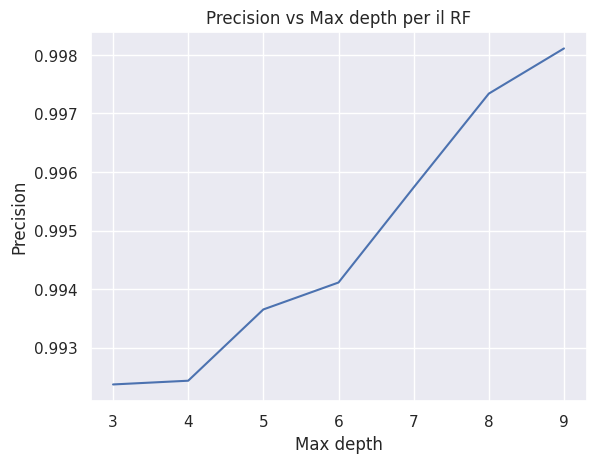

In [33]:
plt.plot(max_depths, precisions)
plt.xlabel("Max depth")
plt.ylabel("Precision")
plt.title("Precision vs Max depth per il RF")
plt.show()

Dal grafico è possibile osservare che al variare della profondità degli alberi nel random forest non segue una particolazre variazione dello score della precision.
Ciò potrebbe indicare che **la situazione potrebbe rimanere pressochè simile a quella attuale anche in un modello più complesso**, **ovvero una assenza di overfitting**.

Per verificare ciò aumentiamo il valore di profondità a 9.

##### Valutazione presenza overfitting con depth = 9

In [34]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Creare il classificatore RF con i parametri ottimali
rf_classifier = RandomForestClassifier(n_estimators = grid_search.best_params_['n_estimators'], max_depth= 9, min_samples_split=grid_search.best_params_['min_samples_split'], min_samples_leaf=grid_search.best_params_['min_samples_leaf'], random_state=42)

# Visualizzare i parametri ottimali
print("Parametri attuali : max_depth = 9, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 50, ")

print ("\n% -------------------- RF test -------------------- %\n")

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Addestrare il modello RF sui dati di train
    rf_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = rf_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'RF df oversampled',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

print ("\n% -------------------- RF train -------------------- %\n")

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Addestrare il modello RF sui dati di train
    rf_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = rf_classifier.predict(X_train)

    # Calcolo metriche di valutazione
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

print ("\n% -------------------------------------------------- %\n")

# Mostrare la tabella delle performance utilizzando tabulate
print("Performance del modello con parametri della Grid Search")
print(tabulate([df_performance.iloc[5]], headers='keys', tablefmt='psql'))

# Aggiorna le performance nel DataFrame
df_performance.loc[df_performance['Modello'] == 'RF df oversampled', ['Recall', 'Precision', 'Accuracy', 'F1-score']] = [model_performance['Recall'], model_performance['Precision'], model_performance['Accuracy'], model_performance['F1-score']]

# Mostrare la tabella delle performance utilizzando tabulate
print("\nPerformance del modello con parametri aggiornati")
print(tabulate([df_performance.iloc[5]], headers='keys', tablefmt='psql'))


Parametri attuali : max_depth = 9, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 50, 

% -------------------- RF test -------------------- %

Average Recall: 0.9638587033621789
Average Precision: 0.9926595561912801
Average Accuracy: 0.9783491213910482
Average F1-score: 0.977997992757515

% -------------------- RF train -------------------- %

Average Recall: 0.9946031054389806
Average Precision: 0.9986980147423201
Average Accuracy: 0.9966532885138962
Average F1-score: 0.9966448330203977

% -------------------------------------------------- %

Performance del modello con parametri della Grid Search
+-------------------+----------+-------------+------------+------------+
| Modello           |   Recall |   Precision |   Accuracy |   F1-score |
|-------------------+----------+-------------+------------+------------|
| RF df oversampled |  0.94127 |    0.993301 |    0.96743 |   0.966496 |
+-------------------+----------+-------------+------------+------------+

Performance del

Come ipotizzato, e' possibile notare una **minimo aumento della differenza tra gli score** delle performance generati dalla valutazione del modello **sui dati di train** e quelli generati **sui dati di test**, rispetto al caso precedente.

Questo indica un **lieve aumento di adattamento del modello ai dati**. Da notare che **non può esserci un'assenza di differenza tra questi valori** in quanto è logico che testare un modello sui dati su cui esso stesso è stato addestrato porterà sempre a performance migliori, l'obiettivo è appunto cercare di minimizzare questo gap.

Possiamo quindi concludere che **il modello attualmente non presenta overfitting o questo è in una forma così lieve da essere tracurabile**.

**Le performance risultano essere leggermente migliorate nel complesso.**


In [35]:
# Mostrare la tabella delle performance utilizzando tabulate
print("\nPerformance dei modelli Random Forest con parametri aggiornati")
print(tabulate(df_performance.iloc[3:6].to_dict(orient='records'), headers='keys', tablefmt='psql'))


Performance dei modelli Random Forest con parametri aggiornati
+--------------------+----------+-------------+------------+------------+
| Modello            |   Recall |   Precision |   Accuracy |   F1-score |
|--------------------+----------+-------------+------------+------------|
| RF df originale    | 0.984184 |    0.981078 |   0.978213 |   0.982555 |
| RF df undersampled | 0.979008 |    0.984385 |   0.977368 |   0.98165  |
| RF df oversampled  | 0.963859 |    0.99266  |   0.978349 |   0.977998 |
+--------------------+----------+-------------+------------+------------+


###**MLP**

####**MLP con dataframe originale**

In [36]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,), (50, 50), (50, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01]
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Creare il classificatore Multi-Layer Perceptron (MLP)
mlp_classifier = MLPClassifier(random_state=42)

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(mlp_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X, y)

# Creare il classificatore MLP con i parametri ottimali
mlp_classifier = MLPClassifier(hidden_layer_sizes=grid_search.best_params_['hidden_layer_sizes'], activation=grid_search.best_params_['activation'], alpha=grid_search.best_params_['alpha'], random_state=42)

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)

print ("\n% -------------------- MLP test -------------------- %\n")

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestrare il modello MLP sui dati di train
    mlp_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = mlp_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'MLP df originale',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)

print ("\n% -------------------- MLP train -------------------- %\n")

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestrare il modello MLP sui dati di train
    mlp_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = mlp_classifier.predict(X_train)

    # Calcolo metriche di valutazione
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

print ("\n% -------------------------------------------------- %\n")

# Mostrare la tabella delle performance utilizzando tabulate
print(tabulate([df_performance.iloc[6]], headers='keys', tablefmt='psql'))


Parametri ottimali: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50)}

% -------------------- MLP test -------------------- %

Average Recall: 0.6006908781387431
Average Precision: 0.7056338159490295
Average Accuracy: 0.5305763543006673
Average F1-score: 0.5190660886200477

% -------------------- MLP train -------------------- %

Average Recall: 0.5998393032449089
Average Precision: 0.6562451211892012
Average Accuracy: 0.5314020922455737
Average F1-score: 0.5168478699940511

% -------------------------------------------------- %

+------------------+----------+-------------+------------+------------+
| Modello          |   Recall |   Precision |   Accuracy |   F1-score |
|------------------+----------+-------------+------------+------------|
| MLP df originale | 0.600691 |    0.705634 |   0.530576 |   0.519066 |
+------------------+----------+-------------+------------+------------+


##### **Discussione risultati MLP con dataset originale**

E' possibile notare una **lieve, e trascurabile, differenza tra gli score** delle performance generati dalla valutazione del modello **sui dati di train** e quelli generati **sui dati di test**. Questo è un segno di assenza di **overfitting** perciò nei passi seguenti si approfondirà tale tesi. Ioltre tutte le performance non sono molto positive, perciò si proverà a rendere il modello più complesso per cercare di aumentare i vari score senza far adattare troppo il modello ai dati.

Si procede quindi con il calcolo e la conseguente stampa della curva **precison vs hidden layer sizes**, per capire come influisce il numero di layer nascosti e di neuroni di questi sullo score della precision

In [37]:
# Definire i parametri da testare con GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,), (50, 50), (50, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01]
}

hidden_layer_sizes = [(20, 20, 20), (20, 20, 20, 20), (50, 50, 50), (50, 100, 50), (100, 100, 100), (50, 100, 100, 50)]
precisions = []

# Ottenere i migliori parametri dalla grid search
best_params = grid_search.best_params_
best_hidden_layer_sizes = best_params['hidden_layer_sizes']
best_activation = best_params['activation']
best_alpha = best_params['alpha']


# Crea il classificatore RF con i parametri variabili
for hidden_layer_size in hidden_layer_sizes:
    clf = MLPClassifier(hidden_layer_sizes = hidden_layer_size, activation = grid_search.best_params_['activation'], alpha = grid_search.best_params_['alpha'], random_state=42)
    clf.fit(X, y)
    y_pred_clf = clf.predict(X)
    precision_clf = precision_score(y, y_pred_clf)
    precisions.append(precision_clf)

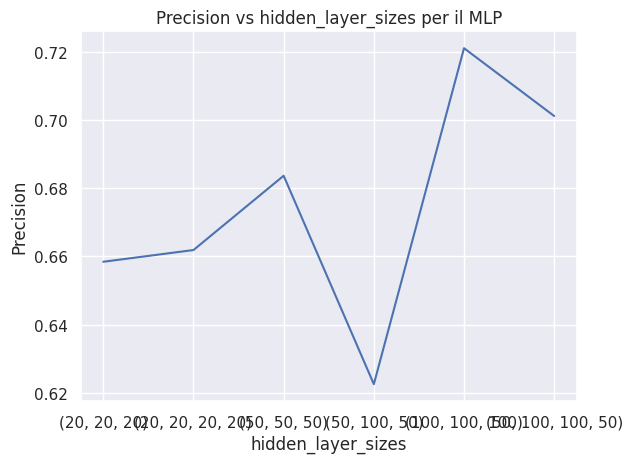

In [38]:
# Converti l'array in una lista di stringhe
hidden_layer_sizes_str = [str(item) for item in hidden_layer_sizes]

plt.plot(hidden_layer_sizes_str, precisions)
plt.xlabel("hidden_layer_sizes")
plt.ylabel("Precision")
plt.title("Precision vs hidden_layer_sizes per il MLP")
plt.show()

Dal grafico è possibile osservare che al variare del numero e della complessità dei layer nascosti anche la precision tende a variare.
Perciò si porva ad usare uno di questi valori** dell'iperparametro "hidden_layer_sizes"** e **riaddestrare il modello aumentandone un pò la complessità**.

Per verificare ciò si sceglie di utilizzare 3 layer, entrambi da 50 neuroni.

###### Riaddestramento e valutazione del modello con hidden_layer_sizes = (50, 50, 50)

In [39]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Creare il classificatore MLP con i parametri aggiornati
mlp_classifier = MLPClassifier(hidden_layer_sizes = (50, 50, 50), activation=grid_search.best_params_['activation'], alpha=grid_search.best_params_['alpha'], random_state=42)

# Visualizzare i parametri aggiornati
print("Parametri attuali: hidden_layer_sizes = (50, 50, 50), activation = relu, alpha = 0.0001")

print ("\n% -------------------- MLP test -------------------- %\n")

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestrare il modello MLP sui dati di train
    mlp_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = mlp_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'MLP df originale',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

print ("\n% -------------------- MLP train -------------------- %\n")

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestrare il modello MLP sui dati di train
    mlp_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = mlp_classifier.predict(X_train)

    # Calcolo metriche di valutazione
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

print ("\n% -------------------------------------------------- %\n")

# Mostrare la tabella delle performance utilizzando tabulate
print("Performance del modello con parametri della Grid Search")
print(tabulate([df_performance.iloc[6]], headers='keys', tablefmt='psql'))

# Aggiorna le performance nel DataFrame
df_performance.loc[df_performance['Modello'] == 'MLP df originale', ['Recall', 'Precision', 'Accuracy', 'F1-score']] = [model_performance['Recall'], model_performance['Precision'], model_performance['Accuracy'], model_performance['F1-score']]

# Mostrare la tabella delle performance utilizzando tabulate
print("\nPerformance del modello con parametri aggiornati")
print(tabulate([df_performance.iloc[6]], headers='keys', tablefmt='psql'))


Parametri attuali: hidden_layer_sizes = (50, 50, 50), activation = relu, alpha = 0.0001

% -------------------- MLP test -------------------- %

Average Recall: 0.9084494254504184
Average Precision: 0.6263330590834796
Average Accuracy: 0.6050598674011282
Average F1-score: 0.7380662524885307

% -------------------- MLP train -------------------- %

Average Recall: 0.917970790044256
Average Precision: 0.6297820130942927
Average Accuracy: 0.61161883874397
Average F1-score: 0.7434968854358901

% -------------------------------------------------- %

Performance del modello con parametri della Grid Search
+------------------+----------+-------------+------------+------------+
| Modello          |   Recall |   Precision |   Accuracy |   F1-score |
|------------------+----------+-------------+------------+------------|
| MLP df originale | 0.600691 |    0.705634 |   0.530576 |   0.519066 |
+------------------+----------+-------------+------------+------------+

Performance del modello con para

E' possibile notare una **assenza di aumento della differenza tra gli score** delle performance generati dalla valutazione del modello **sui dati di train** e quelli generati **sui dati di test**, rispetto al caso precedente.

Questo indica un **assenza di adattamento del modello ai dati**. Da notare che **non può esserci un'assenza di differenza tra questi valori** in quanto è logico che testare un modello sui dati su cui esso stesso è stato addestrato porterà sempre a performance migliori, l'obiettivo è appunto cercare di minimizzare questo gap.

L'obiettivo di aumentare la complessità per migliorare le performance risulta raggiunto,infatti **le performance risultano essere migliorate nel complesso.**

Possiamo quindi concludere che **il modello attualmente non presenta overfitting o questo è in una forma così lieve da essere tracurabile**.




####**MLP con undersampling del dataframe**

In [40]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,), (50, 50), (50, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01]
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Creare il classificatore Multi-Layer Perceptron (MLP)
mlp_classifier = MLPClassifier(random_state=42)

# Applica l'undersampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(mlp_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X_resampled, y_resampled)

# Creare il classificatore MLP con i parametri ottimali
mlp_classifier = MLPClassifier(hidden_layer_sizes=grid_search.best_params_['hidden_layer_sizes'], activation=grid_search.best_params_['activation'], alpha=grid_search.best_params_['alpha'], random_state=42)

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)

print ("\n% -------------------- MLP test -------------------- %\n")

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Addestrare il modello MLP sui dati di train
    mlp_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = mlp_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'MLP df undersampled',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)

print ("\n% -------------------- MLP train -------------------- %\n")

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Addestrare il modello MLP sui dati di train
    mlp_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = mlp_classifier.predict(X_train)

    # Calcolo metriche di valutazione
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

print ("\n% -------------------------------------------------- %\n")

# Mostrare la tabella delle performance utilizzando tabulate
print(tabulate([df_performance.iloc[7]], headers='keys', tablefmt='psql'))


Parametri ottimali: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,)}

% -------------------- MLP test -------------------- %

Average Recall: 0.5268959435626102
Average Precision: 0.5806273777521744
Average Accuracy: 0.5337865123165972
Average F1-score: 0.48601324725725165

% -------------------- MLP train -------------------- %

Average Recall: 0.5213909187736016
Average Precision: 0.537901685718544
Average Accuracy: 0.5268312845360883
Average F1-score: 0.4728800533020173

% -------------------------------------------------- %

+---------------------+----------+-------------+------------+------------+
| Modello             |   Recall |   Precision |   Accuracy |   F1-score |
|---------------------+----------+-------------+------------+------------|
| MLP df undersampled | 0.526896 |    0.580627 |   0.533787 |   0.486013 |
+---------------------+----------+-------------+------------+------------+


##### **Discussione risultati MLP con dataset undersampled**

E' possibile notare una **leggera differenza tra gli score** delle performance generati dalla valutazione del modello **sui dati di train** e quelli generati **sui dati di test**. Questo è un segno di assenza di ** un leggero overfitting** perciò nei passi seguenti si approfondirà tale tesi. Ioltre tutte le performance non sono molto positive, perciò si proverà a rendere il modello più complesso per cercare di aumentare i vari score senza far adattare troppo il modello ai dati.

Si procede quindi con il calcolo e la conseguente stampa della curva **precison vs hidden layer sizes**, per capire come influisce il numero di layer nascosti e di neuroni di questi sullo score della precision

In [41]:
# Definire i parametri da testare con GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,), (50, 50), (50, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01]
}

hidden_layer_sizes = [(10,10), (10, 10, 10), (10, 20, 10), (20, 20), (20, 20, 20), (30, 30), (20, 30, 20), (30, 50, 30)]
precisions = []

# Ottenere i migliori parametri dalla grid search
best_params = grid_search.best_params_
best_hidden_layer_sizes = best_params['hidden_layer_sizes']
best_activation = best_params['activation']
best_alpha = best_params['alpha']


# Crea il classificatore RF con i parametri variabili
for hidden_layer_size in hidden_layer_sizes:
    clf = MLPClassifier(hidden_layer_sizes = hidden_layer_size, activation = grid_search.best_params_['activation'], alpha = grid_search.best_params_['alpha'], random_state=42)
    clf.fit(X_resampled, y_resampled)
    y_pred_clf = clf.predict(X_resampled)
    precision_clf = precision_score(y_resampled, y_pred_clf)
    precisions.append(precision_clf)

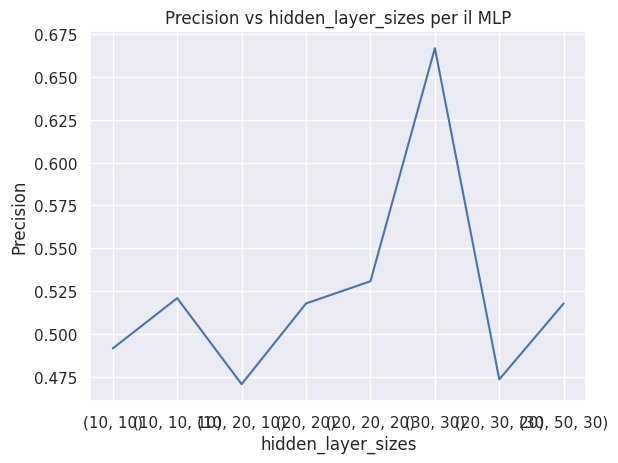

In [42]:
# Converti l'array in una lista di stringhe
hidden_layer_sizes_str = [str(item) for item in hidden_layer_sizes]

plt.plot(hidden_layer_sizes_str, precisions)
plt.xlabel("hidden_layer_sizes")
plt.ylabel("Precision")
plt.title("Precision vs hidden_layer_sizes per il MLP")
plt.show()

Dal grafico è possibile osservare che al variare del numero e della complessità dei layer nascosti anche la precision tende a variare.
Perciò si porva ad usare uno di questi valori **dell'iperparametro "hidden_layer_sizes"** e **riaddestrare il modello aumentandone un pò la complessità**.

Per verificare ciò si sceglie di utilizzare 2 layer, entrambi da 30 neuroni.

###### Valutazione presenza overfitting con hidden_layer_sizes = (30, 30)

In [43]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Creare il classificatore MLP con i parametri ottimali
mlp_classifier = MLPClassifier(hidden_layer_sizes = (30, 30), activation=grid_search.best_params_['activation'], alpha=grid_search.best_params_['alpha'], random_state=42)

# Visualizzare i parametri aggiornati
print("Parametri attuali: hidden_layer_sizes = (30, 30), activation = relu, alpha = 0.0001")

print ("\n% -------------------- MLP test -------------------- %\n")

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Addestrare il modello MLP sui dati di train
    mlp_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = mlp_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'MLP df undersampled',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

print ("\n% -------------------- MLP train -------------------- %\n")

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Addestrare il modello MLP sui dati di train
    mlp_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = mlp_classifier.predict(X_train)

    # Calcolo metriche di valutazione
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

print ("\n% -------------------------------------------------- %\n")

# Mostrare la tabella delle performance utilizzando tabulate
print("Performance del modello con parametri della Grid Search")
print(tabulate([df_performance.iloc[7]], headers='keys', tablefmt='psql'))

# Aggiorna le performance nel DataFrame
df_performance.loc[df_performance['Modello'] == 'MLP df undersampled', ['Recall', 'Precision', 'Accuracy', 'F1-score']] = [model_performance['Recall'], model_performance['Precision'], model_performance['Accuracy'], model_performance['F1-score']]

# Mostrare la tabella delle performance utilizzando tabulate
print("\nPerformance del modello con parametri aggiornati")
print(tabulate([df_performance.iloc[7]], headers='keys', tablefmt='psql'))


Parametri attuali: hidden_layer_sizes = (30, 30), activation = relu, alpha = 0.0001

% -------------------- MLP test -------------------- %

Average Recall: 0.5727206502568821
Average Precision: 0.5091799530162716
Average Accuracy: 0.5040218833528833
Average F1-score: 0.4291541782037179

% -------------------- MLP train -------------------- %

Average Recall: 0.5714140812928483
Average Precision: 0.5063372286226256
Average Accuracy: 0.5041678054145564
Average F1-score: 0.4311078258480773

% -------------------------------------------------- %

Performance del modello con parametri della Grid Search
+---------------------+----------+-------------+------------+------------+
| Modello             |   Recall |   Precision |   Accuracy |   F1-score |
|---------------------+----------+-------------+------------+------------|
| MLP df undersampled | 0.526896 |    0.580627 |   0.533787 |   0.486013 |
+---------------------+----------+-------------+------------+------------+

Performance del mo

E' possibile notare una **assenza di aumento della differenza tra gli score** delle performance generati dalla valutazione del modello **sui dati di train** e quelli generati **sui dati di test**, rispetto al caso precedente.

Questo indica un **assenza di adattamento del modello ai dati**. Da notare che **non può esserci un'assenza di differenza tra questi valori** in quanto è logico che testare un modello sui dati su cui esso stesso è stato addestrato porterà sempre a performance migliori, l'obiettivo è appunto cercare di minimizzare questo gap.

L'obiettivo di aumentare la complessità per migliorare le performance **NON** risulta raggiunto,infatti **le performance risultano essere circa invariate nel complesso.**

Possiamo quindi concludere che **il modello attualmente non presenta overfitting o questo è in una forma così lieve da essere tracurabile**.

Si potrebbe quindi procedere con nuove valutazioni empiriche sull'aumento della complessità ai fini dell'aumento degli score delle performance, ma per questioni di tempo in questo caso di studio ciò non verrà approfondito.

####**MLP con oversampling del dataframe**

In [44]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,), (50, 50), (50, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01]
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Creare il classificatore Multi-Layer Perceptron (MLP)
mlp_classifier = MLPClassifier(random_state=42)

# Applica l'oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(mlp_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X_resampled, y_resampled)

# Creare il classificatore MLP con i parametri ottimali
mlp_classifier = MLPClassifier(hidden_layer_sizes=grid_search.best_params_['hidden_layer_sizes'], activation=grid_search.best_params_['activation'], alpha=grid_search.best_params_['alpha'], random_state=42)

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)

print ("\n% -------------------- MLP test -------------------- %\n")

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Addestrare il modello MLP sui dati di train
    mlp_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = mlp_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'MLP df oversampled',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)

print ("\n% -------------------- MLP train -------------------- %\n")

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Addestrare il modello MLP sui dati di train
    mlp_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = mlp_classifier.predict(X_train)

    # Calcolo metriche di valutazione
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

print ("\n% -------------------------------------------------- %\n")

# Mostrare la tabella delle performance utilizzando tabulate
print(tabulate([df_performance.iloc[8]], headers='keys', tablefmt='psql'))


Parametri ottimali: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50)}

% -------------------- MLP test -------------------- %

Average Recall: 0.47861682508157183
Average Precision: 0.6230352402782042
Average Accuracy: 0.5096041657816859
Average F1-score: 0.3781044982740147

% -------------------- MLP train -------------------- %

Average Recall: 0.4913293399760959
Average Precision: 0.5961048542809779
Average Accuracy: 0.5162522983672295
Average F1-score: 0.3878958268305256

% -------------------------------------------------- %

+--------------------+----------+-------------+------------+------------+
| Modello            |   Recall |   Precision |   Accuracy |   F1-score |
|--------------------+----------+-------------+------------+------------|
| MLP df oversampled | 0.478617 |    0.623035 |   0.509604 |   0.378104 |
+--------------------+----------+-------------+------------+------------+


##### **Discussione risultati MLP con dataset oversampled**

E' possibile notare una **lieve, e trascurabile, differenza tra gli score** delle performance generati dalla valutazione del modello **sui dati di train** e quelli generati **sui dati di test**. Questo è un segno di assenza di **overfitting** perciò nei passi seguenti si approfondirà tale tesi. Ioltre tutte le performance non sono molto positive, perciò si proverà a rendere il modello più complesso per cercare di aumentare i vari score senza far adattare troppo il modello ai dati.

Si procede quindi con il calcolo e la conseguente stampa della curva **precison vs hidden layer sizes**, per capire come influisce il numero di layer nascosti e di neuroni di questi sullo score della precision

In [45]:
# Definire i parametri da testare con GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,), (50, 50), (50, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01]
}

hidden_layer_sizes = [(30, 30), (20, 20, 20), (20, 30, 20), (30, 30, 30), (30, 30, 30, 30), (30, 50, 30), (60, 60), (75, 75), (75, 75, 75)]
precisions = []

# Ottenere i migliori parametri dalla grid search
best_params = grid_search.best_params_
best_hidden_layer_sizes = best_params['hidden_layer_sizes']
best_activation = best_params['activation']
best_alpha = best_params['alpha']


# Crea il classificatore MLP con i parametri variabili
for hidden_layer_size in hidden_layer_sizes:
    clf = MLPClassifier(hidden_layer_sizes = hidden_layer_size, activation = grid_search.best_params_['activation'], alpha = grid_search.best_params_['alpha'], random_state=42)
    clf.fit(X_resampled, y_resampled)
    y_pred_clf = clf.predict(X_resampled)
    precision_clf = precision_score(y_resampled, y_pred_clf)
    precisions.append(precision_clf)

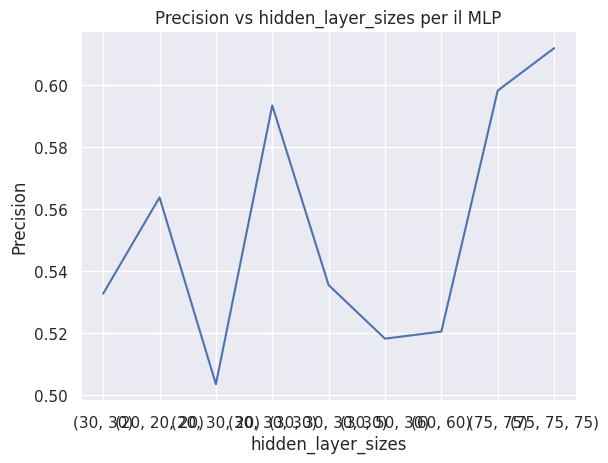

In [46]:
# Converti l'array in una lista di stringhe
hidden_layer_sizes_str = [str(item) for item in hidden_layer_sizes]

plt.plot(hidden_layer_sizes_str, precisions)
plt.xlabel("hidden_layer_sizes")
plt.ylabel("Precision")
plt.title("Precision vs hidden_layer_sizes per il MLP")
plt.show()

Dal grafico è possibile osservare che al variare del numero e della complessità dei layer nascosti anche la precision tende a variare.
Perciò si porva ad usare uno di questi valori **dell'iperparametro "hidden_layer_sizes"** e **riaddestrare il modello aumentandone un pò la complessità**.

Per verificare ciò si sceglie di utilizzare 3 layer, entrambi da 75 neuroni.

###### Valutazione presenza overfitting con hidden_layer_sizes = (75, 75, 75)

In [47]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Definire i parametri da testare con GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creare l'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Creare il classificatore MLP con i parametri ottimali
mlp_classifier = MLPClassifier(hidden_layer_sizes = (75, 75, 75), activation=grid_search.best_params_['activation'], alpha=grid_search.best_params_['alpha'], random_state=42)

# Visualizzare i parametri aggiornati
print("Parametri ottimali: hidden_layer_sizes = (75, 75, 75), activation = relu, alpha = 0.0001")

print ("\n% -------------------- MLP test -------------------- %\n")

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Addestrare il modello MLP sui dati di train
    mlp_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = mlp_classifier.predict(X_test)

    # Calcolo metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'MLP df oversampled',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

print ("\n% -------------------- MLP train -------------------- %\n")

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Effettuare la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Addestrare il modello MLP sui dati di train
    mlp_classifier.fit(X_train, y_train)

    # Effettuare le previsioni sul set di test
    y_pred = mlp_classifier.predict(X_train)

    # Calcolo metriche di valutazione
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)


# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

print ("\n% -------------------------------------------------- %\n")

# Mostrare la tabella delle performance utilizzando tabulate
print("Performance del modello con parametri della Grid Search")
print(tabulate([df_performance.iloc[8]], headers='keys', tablefmt='psql'))

# Aggiorna le performance nel DataFrame
df_performance.loc[df_performance['Modello'] == 'MLP df oversampled', ['Recall', 'Precision', 'Accuracy', 'F1-score']] = [model_performance['Recall'], model_performance['Precision'], model_performance['Accuracy'], model_performance['F1-score']]

# Mostrare la tabella delle performance utilizzando tabulate
print("\nPerformance del modello con parametri aggiornati")
print(tabulate([df_performance.iloc[8]], headers='keys', tablefmt='psql'))


Parametri ottimali: hidden_layer_sizes = (75, 75, 75), activation = relu, alpha = 0.0001

% -------------------- MLP test -------------------- %

Average Recall: 0.478611150517804
Average Precision: 0.5925354856842129
Average Accuracy: 0.518073786160316
Average F1-score: 0.38528912222715594

% -------------------- MLP train -------------------- %

Average Recall: 0.4810409852847761
Average Precision: 0.5889827551825922
Average Accuracy: 0.5207699584915535
Average F1-score: 0.3833695606082932

% -------------------------------------------------- %

Performance del modello con parametri della Grid Search
+--------------------+----------+-------------+------------+------------+
| Modello            |   Recall |   Precision |   Accuracy |   F1-score |
|--------------------+----------+-------------+------------+------------|
| MLP df oversampled | 0.478617 |    0.623035 |   0.509604 |   0.378104 |
+--------------------+----------+-------------+------------+------------+

Performance del mod

E' possibile notare una **assenza di aumento della differenza tra gli score** delle performance generati dalla valutazione del modello **sui dati di train** e quelli generati **sui dati di test**, rispetto al caso precedente.

Questo indica un **assenza di adattamento del modello ai dati**. Da notare che **non può esserci un'assenza di differenza tra questi valori** in quanto è logico che testare un modello sui dati su cui esso stesso è stato addestrato porterà sempre a performance migliori, l'obiettivo è appunto cercare di minimizzare questo gap.

L'obiettivo di aumentare la complessità per migliorare le performance **NON** risulta raggiunto, infatti **le performance risultano essere circa invariate nel complesso.**

Possiamo quindi concludere che **il modello attualmente non presenta overfitting o questo è in una forma così lieve da essere tracurabile**.

Si potrebbe quindi procedere con nuove valutazioni empiriche sull'aumento della complessità ai fini dell'aumento degli score delle performance, ma per questioni di tempo in questo caso di studio ciò non verrà approfondito.

In [48]:
# Mostrare la tabella delle performance utilizzando tabulate
print("\nPerformance dei modelli Random Forest con parametri aggiornati")
print(tabulate(df_performance.iloc[7:10].to_dict(orient='records'), headers='keys', tablefmt='psql'))


Performance dei modelli Random Forest con parametri aggiornati
+---------------------+----------+-------------+------------+------------+
| Modello             |   Recall |   Precision |   Accuracy |   F1-score |
|---------------------+----------+-------------+------------+------------|
| MLP df undersampled | 0.572721 |    0.50918  |   0.504022 |   0.429154 |
| MLP df oversampled  | 0.478611 |    0.592535 |   0.518074 |   0.385289 |
+---------------------+----------+-------------+------------+------------+


## **Apprendimento con modello probabilistico**

In [49]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzazione delle liste per le performance
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Definizione dei parametri da testare con GridSearchCV
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
}

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creazione dell'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Creazione del classificatore Naive Bayes
nb_classifier = GaussianNB()

# Creare l'oggetto GridSearchCV
grid_search = GridSearchCV(nb_classifier, param_grid, scoring=scoring, refit='precision', cv=stratified_kfold)

# Effettuare la ricerca dei parametri ottimali utilizzando GridSearchCV
grid_search.fit(X, y)

# Creare il classificatore k-NN con i parametri ottimali
nb_classifier = GaussianNB(var_smoothing=grid_search.best_params_['var_smoothing'])

# Visualizzare i parametri ottimali
print("Parametri ottimali:", grid_search.best_params_)

print ("\n% -------------------- NB test -------------------- %\n")

# Esegui la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestramento del modello Naive Bayes sui dati di addestramento
    nb_classifier.fit(X_train, y_train)

    # Previsioni sul set di test
    y_pred = nb_classifier.predict(X_test)

    # Calcolo delle metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)

# Calcolo della media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'NB df originale',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

df_performance = df_performance.append(model_performance, ignore_index=True)

print ("\n% -------------------- NB train -------------------- %\n")

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Esegui la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestramento del modello Naive Bayes sui dati di addestramento
    nb_classifier.fit(X_train, y_train)

    # Previsioni sul set di test
    y_pred = nb_classifier.predict(X_train)

    # Calcolo delle metriche di valutazione
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)

# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

print ("\n% -------------------------------------------------- %\n")

# Mostrare la tabella delle performance utilizzando tabulate
print(tabulate([df_performance.iloc[9]], headers='keys', tablefmt='psql'))

Parametri ottimali: {'var_smoothing': 1e-09}

% -------------------- NB test -------------------- %

Average Recall: 0.9702596112923819
Average Precision: 0.7302828783379078
Average Accuracy: 0.7584875372453299
Average F1-score: 0.8333143922931445

% -------------------- NB train -------------------- %

Average Recall: 0.9731007666475924
Average Precision: 0.735813643038181
Average Accuracy: 0.7658831209837772
Average F1-score: 0.8379804415874602

% -------------------------------------------------- %

+-----------------+----------+-------------+------------+------------+
| Modello         |   Recall |   Precision |   Accuracy |   F1-score |
|-----------------+----------+-------------+------------+------------|
| NB df originale |  0.97026 |    0.730283 |   0.758488 |   0.833314 |
+-----------------+----------+-------------+------------+------------+


##### **Discussione risultati NB con dataset originale**

E' possibile notare una **lieve, e trascurabile, differenza tra gli score** delle performance generati dalla valutazione del modello **sui dati di train** e quelli generati **sui dati di test**. Questo è un segno di **assenza di overfitting** perciò nei passi seguenti si approfondirà tale tesi.

Si procede quindi con il calcolo e la conseguente stampa della curva **precison vs var_smoothing**, per capire come influisce la variazione di tale parametro sullo score della precision

In [50]:
# Definizione dei parametri da testare con GridSearchCV
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}

var_smoothings = [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
precisions = []

# Ottenere i migliori parametri dalla grid search
best_params = grid_search.best_params_
best_var_smoothing = best_params['var_smoothing']

# Crea il classificatore KNN con i parametri variabili
for var_smoothing in var_smoothings:
    clf = GaussianNB(var_smoothing = var_smoothing)
    clf.fit(X, y)
    y_pred_clf = clf.predict(X)
    precision_clf = precision_score(y, y_pred_clf)
    precisions.append(precision_clf)

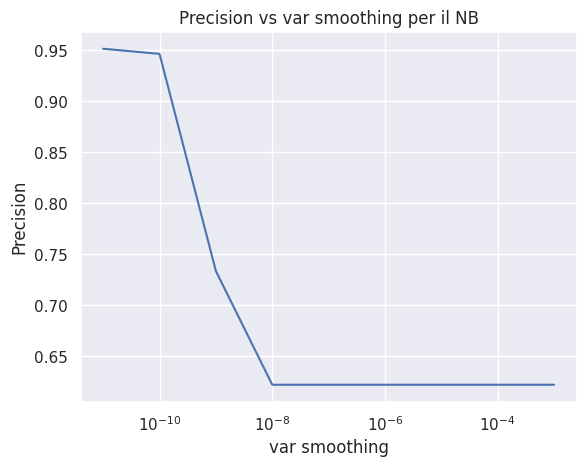

In [51]:
plt.plot(var_smoothings, precisions)
plt.xlabel("var smoothing")
plt.ylabel("Precision")
plt.title("Precision vs var smoothing per il NB")
plt.xscale('log')
plt.show()

Il grafico porta un aumento netto dello score della precisione tra 1e-11 ed 1e-8, perciò si procede con il ricalcolo del grafico concentrandosi soltanto su questa porzione.

In [52]:
# Definizione dei parametri da testare con GridSearchCV
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}

var_smoothings = np.logspace(start = -11, stop = -8.5, num=50, dtype=None, endpoint=True)

precisions = []

# Ottenere i migliori parametri dalla grid search
best_params = grid_search.best_params_
best_var_smoothing = best_params['var_smoothing']

# Crea il classificatore KNN con i parametri variabili
for var_smoothing in var_smoothings:
    clf = GaussianNB(var_smoothing = var_smoothing)
    clf.fit(X, y)
    y_pred_clf = clf.predict(X)
    precision_clf = precision_score(y, y_pred_clf)
    precisions.append(precision_clf)

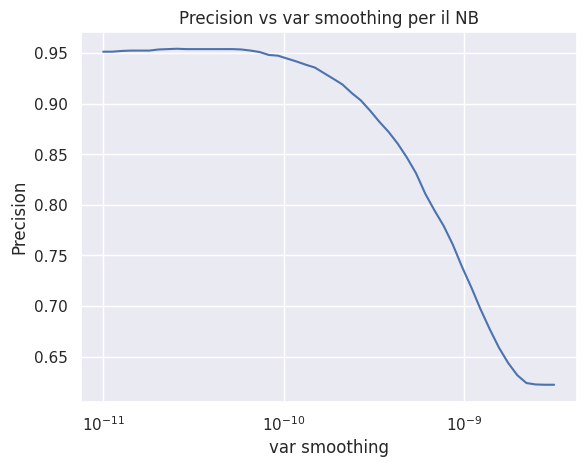

In [53]:
plt.plot(var_smoothings, precisions)
plt.xlabel("var smoothing")
plt.ylabel("Precision")
plt.title("Precision vs var smoothing per il NB")
plt.xscale('log')
plt.show()

Dal grafico è possibile osservare che al diminuire del parametro in questione aumenta il valore della precision.

proviamo quindi a dimiuire tale valore per capire come si comporta il modello, si sceglierà var_smoothing = 1e-10.

##### Valutazione presenza overfitting da differenza tra performance delle valutazioni sui dati di train e di test

In [54]:
# Definizione il numero di fold per la cross-validation
k_folds = 10

# Inizializzazione delle liste per le performance
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Definire le metriche da utilizzare per la valutazione
scoring = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

# Creazione dell'oggetto StratifiedKFold per la k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Creare il classificatore NB con i parametri ottimali
nb_classifier = GaussianNB(var_smoothing = 1e-10)

# Visualizzare i parametri ottimali
print("Parametri aggiornati: var_smoothing = 1e-10")

print ("\n% -------------------- NB test -------------------- %\n")

# Esegui la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestramento del modello Naive Bayes sui dati di addestramento
    nb_classifier.fit(X_train, y_train)

    # Previsioni sul set di test
    y_pred = nb_classifier.predict(X_test)

    # Calcolo delle metriche di valutazione
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)

# Calcolo della media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

model_performance = {
    'Modello': 'NB df originale',
    'Recall': average_recall,
    'Precision': average_precision,
    'Accuracy': average_accuracy,
    'F1-score': average_f1_score
}

print ("\n% -------------------- NB train -------------------- %\n")

# Inizializzare una lista
recalls = []
precisions = []
accuracies = []
f1_scores = []

# Esegui la k-fold cross-validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestramento del modello Naive Bayes sui dati di addestramento
    nb_classifier.fit(X_train, y_train)

    # Previsioni sul set di test
    y_pred = nb_classifier.predict(X_train)

    # Calcolo delle metriche di valutazione
    recall = recall_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    recalls.append(recall)
    precisions.append(precision)
    accuracies.append(accuracy)
    f1_scores.append(f1)

# Calcolare la media delle performance di tutti i fold
average_recall = sum(recalls) / len(recalls)
average_precision = sum(precisions) / len(precisions)
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)

print("Average Recall:", average_recall)
print("Average Precision:", average_precision)
print("Average Accuracy:", average_accuracy)
print("Average F1-score:", average_f1_score)

print ("\n% -------------------------------------------------- %\n")

# Mostrare la tabella delle performance utilizzando tabulate
print("Performance del modello con parametri della Grid Search")
print(tabulate([df_performance.iloc[9]], headers='keys', tablefmt='psql'))

# Aggiorna le performance nel DataFrame
df_performance.loc[df_performance['Modello'] == 'NB df originale', ['Recall', 'Precision', 'Accuracy', 'F1-score']] = [model_performance['Recall'], model_performance['Precision'], model_performance['Accuracy'], model_performance['F1-score']]

# Mostrare la tabella delle performance utilizzando tabulate
print("\nPerformance del modello con parametri aggiornati")
print(tabulate([df_performance.iloc[9]], headers='keys', tablefmt='psql'))

Parametri aggiornati: var_smoothing = 1e-10

% -------------------- NB test -------------------- %

Average Recall: 0.9356192367711731
Average Precision: 0.9434472601083519
Average Accuracy: 0.9248040153489244
Average F1-score: 0.939359912978907

% -------------------- NB train -------------------- %

Average Recall: 0.9359521847093966
Average Precision: 0.945969396126328
Average Accuracy: 0.9268889208567994
Average F1-score: 0.9409323265979094

% -------------------------------------------------- %

Performance del modello con parametri della Grid Search
+-----------------+----------+-------------+------------+------------+
| Modello         |   Recall |   Precision |   Accuracy |   F1-score |
|-----------------+----------+-------------+------------+------------|
| NB df originale |  0.97026 |    0.730283 |   0.758488 |   0.833314 |
+-----------------+----------+-------------+------------+------------+

Performance del modello con parametri aggiornati
+-----------------+----------+---

E' possibile notare una **assenza di aumento della differenza tra gli score** delle performance generati dalla valutazione del modello **sui dati di train** e quelli generati **sui dati di test**, rispetto al caso precedente.

Questo indica un di **assenza di aumento di adattamento del modello ai dati**. Da notare che **non può esserci un'assenza di differenza tra questi valori** in quanto è logico che testare un modello sui dati su cui esso stesso è stato addestrato porterà sempre a performance migliori, l'obiettivo è appunto cercare di minimizzare questo gap.

**Le performance risultano essere decisamente migliorate nel complesso.**

Possiamo quindi concludere che **il modello attualmente non presenta overfitting o questo è in una forma così lieve da essere tracurabile**.


##### **Osservazioni**

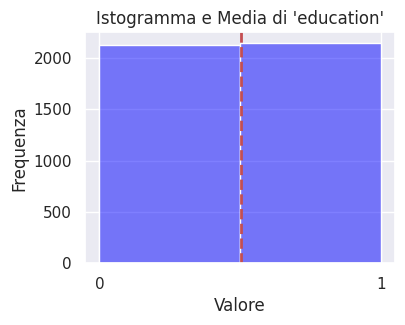

Feature: education
  Mean Value: 0.50
  Class 0: Mean Probability = 0.503
  Class 1: Mean Probability = 0.497



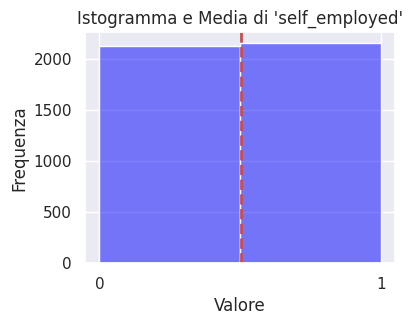

Feature: self_employed
  Mean Value: 0.50
  Class 0: Mean Probability = 0.392
  Class 1: Mean Probability = 0.608



In [55]:
# Calcola la media dei valori per ogni feature, massimo e minimo di ciascuna feature
mean_values = np.mean(X, axis=0)
max_values = X.max()
min_values = X.min()

# Creare il classificatore NB con i parametri ottimali
nb_classifier = GaussianNB(var_smoothing = 1e-9)
nb_classifier.fit(X, y)

# Calcola le probabilità predette per ciascuna classe per ogni istanza
predicted_probabilities = nb_classifier.predict_proba(X)

# Mostra un titolo utilizzando HTML
title = "<h1>Features binarie</h1>"
display(HTML(title))

# Identifica le feature binarie (0 e 1)
binary_features = [col for col in X.columns if set(X[col]) == {0, 1}]

# Visualizza il valore medio di ogni feature binaria
for feature_name in binary_features:
    plt.figure(figsize=(4, 3))

    # Istogramma sovrapposto alla cardinalità delle istanze
    sns.histplot(X[feature_name], bins=2, kde=False, color='blue', alpha=0.5, label='Frequenza')

    # Linea verticale per il valore medio
    plt.axvline(x=mean_values[feature_name], color='r', linestyle='dashed', linewidth=2, label='Media')

    plt.title(f"Istogramma e Media di '{feature_name}'")
    plt.xlabel("Valore")
    plt.ylabel("Frequenza")
    plt.xticks([0, 1])
    plt.show()

    print(f"Feature: {feature_name}")
    print(f"  Mean Value: {mean_values[feature_name]:.2f}")

    for class_label, class_probs in enumerate(predicted_probabilities.T):
        print(f"  Class {class_label}: Mean Probability = {class_probs[X.columns.get_loc(feature_name)]:.3f}")

    print()


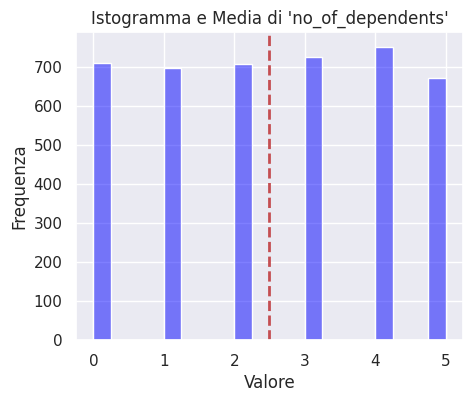

Feature: no_of_dependents
  Mean Value: 2.50
  Class 0: Mean Probability = 0.220
  Class 1: Mean Probability = 0.780



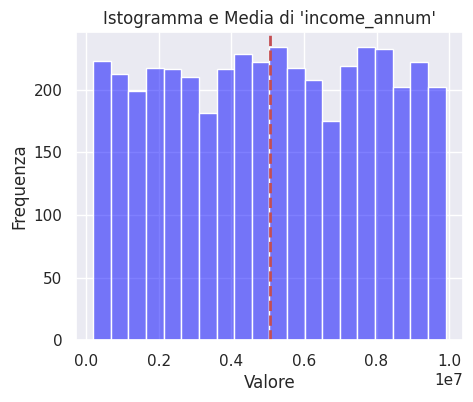

Feature: income_annum
  Mean Value: 5059123.92
  Class 0: Mean Probability = 0.449
  Class 1: Mean Probability = 0.551



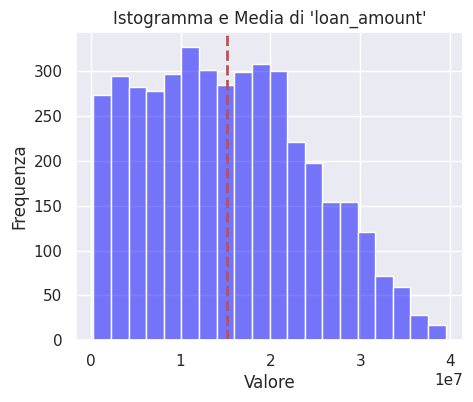

Feature: loan_amount
  Mean Value: 15133450.46
  Class 0: Mean Probability = 0.526
  Class 1: Mean Probability = 0.474



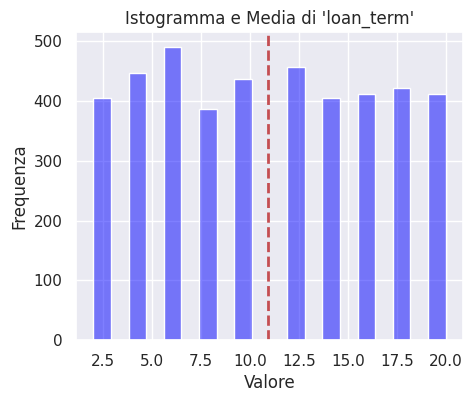

Feature: loan_term
  Mean Value: 10.90
  Class 0: Mean Probability = 0.579
  Class 1: Mean Probability = 0.421



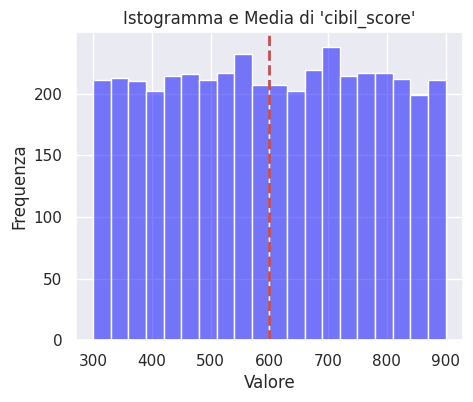

Feature: cibil_score
  Mean Value: 599.94
  Class 0: Mean Probability = 0.286
  Class 1: Mean Probability = 0.714



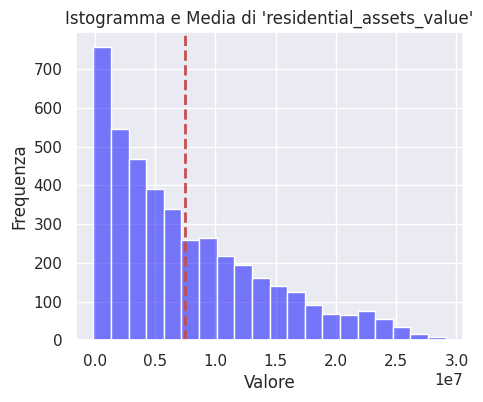

Feature: residential_assets_value
  Mean Value: 7472616.54
  Class 0: Mean Probability = 0.547
  Class 1: Mean Probability = 0.453



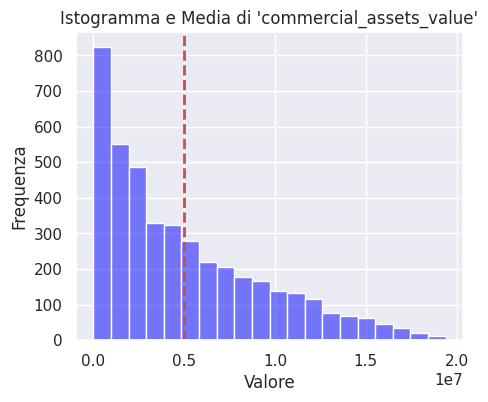

Feature: commercial_assets_value
  Mean Value: 4973155.31
  Class 0: Mean Probability = 0.214
  Class 1: Mean Probability = 0.786



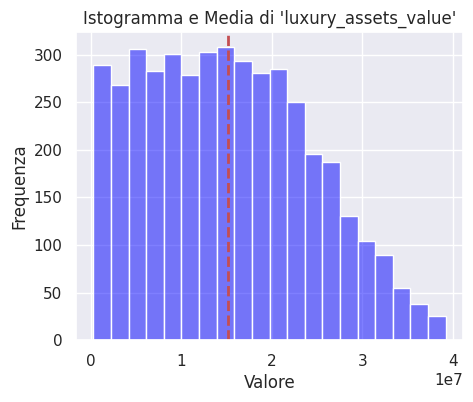

Feature: luxury_assets_value
  Mean Value: 15126305.93
  Class 0: Mean Probability = 0.481
  Class 1: Mean Probability = 0.519



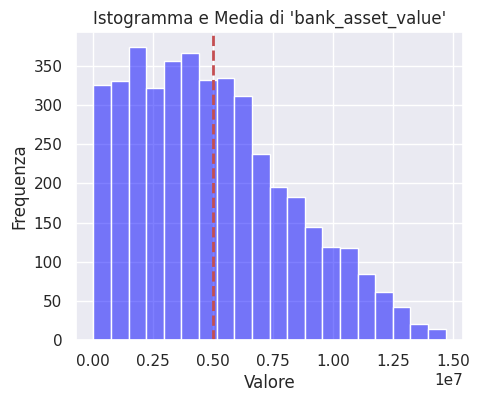

Feature: bank_asset_value
  Mean Value: 4976692.43
  Class 0: Mean Probability = 0.410
  Class 1: Mean Probability = 0.590



In [56]:
# Mostra un titolo utilizzando HTML
title = "<h1>Features continue</h1>"
display(HTML(title))

# Seleziona le feature continue rimuovendo quelle binarie
continuous_features = X.drop(columns=binary_features)

# Visualizza il valore medio di ogni feature binaria
for feature_name in continuous_features:
    plt.figure(figsize=(5, 4))

    # Istogramma sovrapposto alla cardinalità delle istanze
    sns.histplot(continuous_features[feature_name], bins=20, kde=False, color='blue', alpha=0.5, label='Frequenza')

    # Linea verticale per il valore medio
    plt.axvline(x=mean_values[feature_name], color='r', linestyle='dashed', linewidth=2, label='Media')

    plt.title(f"Istogramma e Media di '{feature_name}'")
    plt.xlabel("Valore")
    plt.ylabel("Frequenza")
    plt.show()

    print(f"Feature: {feature_name}")
    print(f"  Mean Value: {mean_values[feature_name]:.2f}")

    for class_label, class_probs in enumerate(predicted_probabilities.T):
        print(f"  Class {class_label}: Mean Probability = {class_probs[X.columns.get_loc(feature_name)]:.3f}")

    print()

I grafici qui sopra mostrati possono sembrare banale e non informativi, in realtà tutt'altro. In particolare possiamo notare che:

1.   **Ottimo bilanciamento** tra i valori delle features degli esempi per quasi la totalità delle features
2.   Le probabilità medie stimate per alcune feature in riferimento all'appartenenza degli esempi ad una classe sembrano **indicativi della composizione degli esempi della feature stessa**.

**Questo due osservazioni portano a pensare che i valori spartiacque che potrebbe utilizzare un istituto bancario per la decisione dell'approvazione di un mutuo o meno sono esattamente i valori medi per ogni feature (che in alcuni casi corrisponde alla media).**

Si proverà quindi successivamente a costruire una condizione basata sui valori medi delle feature le quali hanno un valore simile tra media e valore medio, ovvero le seguenti :

- income_annum
- loan_amount
- residential_asset_value
- luxury_asset_value
- bank_asset_value

**Le osservazioni fatte in questo blocco verrano tenute in considerazione nel momento della creazione delle regeole della base di conoscenza.**


##**Discussione risultati**

In [57]:
# Mostrare la tabella delle performance utilizzando tabulate
print(tabulate(df_performance, headers='keys', tablefmt='psql'))


+----+---------------------+----------+-------------+------------+------------+
|    | Modello             |   Recall |   Precision |   Accuracy |   F1-score |
|----+---------------------+----------+-------------+------------+------------|
|  0 | KNN df originale    | 0.849772 |    0.625925 |   0.590544 |   0.720811 |
|  1 | KNN df undersampled | 0.538785 |    0.51107  |   0.512076 |   0.524238 |
|  2 | KNN df oversampled  | 0.549328 |    0.574479 |   0.570598 |   0.561209 |
|  3 | RF df originale     | 0.984184 |    0.981078 |   0.978213 |   0.982555 |
|  4 | RF df undersampled  | 0.979008 |    0.984385 |   0.977368 |   0.98165  |
|  5 | RF df oversampled   | 0.963859 |    0.99266  |   0.978349 |   0.977998 |
|  6 | MLP df originale    | 0.908449 |    0.626333 |   0.60506  |   0.738066 |
|  7 | MLP df undersampled | 0.572721 |    0.50918  |   0.504022 |   0.429154 |
|  8 | MLP df oversampled  | 0.478611 |    0.592535 |   0.518074 |   0.385289 |
|  9 | NB df originale     | 0.935619 | 

Conclusioni finali sul capitolo dedicato all'apprendimento supervisionato di modelli classici e del modello probabilistico Naive Bayes.

1.   i migliori classificatori per questo dataset sono stati il **Random Forest** e il **Naive Bayes**
2.   effettuare **l'oversampled** o **l'undersampled** del dataset non ha portato **quasi mai ad un miglioramento delle performance** ma solitamente bensì ad un **aumento dell'overfitting**.


## **Knowledge base**

Questo capitolo trattera:

*   La creazione della knowledge base
*   La creazione e l'utilizzo di query
*   Il calcolo delle predizioni basate sui risultati delle query
*   La discussione dei risultati
*   L'utilizzo di test per la verifica della KB


### **Creazione e popolamento della knowledge base con fatti e regole**

Di seguito sono riportati i caricamenti dei file prolog riguardanti la creazione della base di conoscenza con fatti e regole. I file in questione sono stati generati come output di un piccolo script creato appositamente per la creazione di istanze di predicati, che si traducono appunto in fatti della knowledge base.

Il file contenente le regole non era creabile in modo automatico in quanto è formato solo dalle definizioni di regole.

In [58]:
!pip install pyswip
!apt-get install -y swi-prolog

from pyswip import Prolog
prolog = Prolog()

prolog.consult('/content/drive/MyDrive/Progetto Icon/Prolog/richieste.pl')
prolog.consult('/content/drive/MyDrive/Progetto Icon/Prolog/attivi.pl')
prolog.consult('/content/drive/MyDrive/Progetto Icon/Prolog/passivi.pl')
prolog.consult('/content/drive/MyDrive/Progetto Icon/Prolog/garanzie.pl')
prolog.consult('/content/drive/MyDrive/Progetto Icon/Prolog/solvibilita.pl')
prolog.consult('/content/drive/MyDrive/Progetto Icon/Prolog/regole.pl')


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  autopoint debhelper debugedit dh-autoreconf dh-strip-nondeterminism dwz
  gettext gettext-base intltool-debian libarchive-cpio-perl
  libarchive-zip-perl libdebhelper-perl libfile-stripnondeterminism-perl
  libmail-sendmail-perl libossp-uuid16 libsub-override-perl
  libsys-hostname-long-perl libtool po-debconf swi-prolog-core
  swi-prolog-core-packages swi-prolog-doc swi-prolog-nox swi-prolog-x
Suggested packages:
  dh-make gettext-doc libasprintf-dev libgettextpo-dev uuid libtool-doc
  gcj-jdk libmail-box-perl elpa-ediprolog swi-prolog-java swi-prolog-odbc
  swi-prolog-bdb
The following NEW packages will be installed:
  autopoint debhelper debugedit dh-autoreconf dh-strip-nondeterminism dwz
  gettext gettext-base intltool-debian libarchive-cpio-perl
  libarchive-zip-perl libdebhelper-perl libfile-stripnondeterminism-perl
  libmail-send

In [59]:
# Mostra la definizione di fatti e regole
print ("% -------------------- FATTI -------------------- %\n")
print("richiesta (Loan_id, No_of_dependents, Education, Self_employed, Income_annum, Loan_amount, Loan_term, Cibil_score, Residential_assets_value, Commercial_assets_value, Luxury_assets_value, Bank_asset_value, Loan_status).")
print("attivo (Loan_id, Income_annum, Commercial_assets_value, Bank_asset_value).")
print("passivo (Loan_id, No_of_dependents, Loan_amount, Luxury_assets_value).")
print("garanzie (Loan_id, Residential_assets_value, Commercial_assets_value, Luxury_assets_value, Bank_asset_value).")
print("solvibilita (Loan_id, Loan_amount, Loan_term, Cibil_score).")
print("\n% -------------------- REGOLE -------------------- %\n")
with open('/content/drive/MyDrive/Progetto Icon/Prolog/regole.pl', 'r', encoding='ISO-8859-1') as file:
    content = file.read()
    print(content)
print("% ----------------------------------------------- %\n")


% -------------------- FATTI -------------------- %

richiesta (Loan_id, No_of_dependents, Education, Self_employed, Income_annum, Loan_amount, Loan_term, Cibil_score, Residential_assets_value, Commercial_assets_value, Luxury_assets_value, Bank_asset_value, Loan_status).
attivo (Loan_id, Income_annum, Commercial_assets_value, Bank_asset_value).
passivo (Loan_id, No_of_dependents, Loan_amount, Luxury_assets_value).
garanzie (Loan_id, Residential_assets_value, Commercial_assets_value, Luxury_assets_value, Bank_asset_value).
solvibilita (Loan_id, Loan_amount, Loan_term, Cibil_score).

% -------------------- REGOLE -------------------- %

% Regola: Approva il prestito se il valore degli asset commerciali
% supera il valore della richiesta di prestito e il valore
% degli asset sul conto corrente supera il 10% dell'ammontare del
% prestito richiesto (serve come anticipo solitamente)
approva_per_attivo(Loan_id) :-
    attivo(Loan_id, Income_annum, Commercial_assets_value, Bank_asset_value),
 

### **Creazione ed uso delle query per l'applicazione delle regole**

Si prosegue con la creazione di una query per l'interrogazione di ogni regola presenta nella KB.

Và notato che il seguente codice tratterà in modo separato il calcolo dei prestiti approvati su regole create in maniera empirica ed il calcolo sulla regola basata sulle osservazioni fatte nella fase di apprendimento probabilistico così da poterne confrontare i risultati.

In [60]:
# Ottieni gli ID dei prestiti dalla base di conoscenza
loan_ids = list(prolog.query("attivo(Loan_id, _, _, _)."))

# Lista per memorizzare i prestiti approvati
prestiti_approvati = []
prestiti_approvati_per_osservazioni = []

# Itera su ogni valore di loan_id
for result in loan_ids:

    loan_id = result["Loan_id"]

    # Creazione delle query per ogni regola
    query1 = f"approva_per_attivo({loan_id})."
    query2 = f"approva_per_reddito({loan_id})."
    query3 = f"approva_per_garanzie({loan_id})."
    query4 = f"approva_per_gestione_finanze({loan_id})."
    query5 = f"approva_per_piccoli_prestiti({loan_id})."
    query6 = f"approva_per_solvibilita({loan_id})."

    query7 = f"approva_per_osservazioni({loan_id})."

    # Risultati delle query
    solutions1 = list(prolog.query(query1))
    solutions2 = list(prolog.query(query2))
    solutions3 = list(prolog.query(query3))
    solutions4 = list(prolog.query(query4))
    solutions5 = list(prolog.query(query5))
    solutions6 = list(prolog.query(query6))

    solutions7 = list(prolog.query(query7))


    if solutions1 or solutions2 or solutions3 or solutions4 or solutions5 or solutions6:
        prestiti_approvati.append(loan_id)

    if solutions7:
        prestiti_approvati_per_osservazioni.append(loan_id)

print("Prestiti approvati:", len(prestiti_approvati))
print("Prestiti approvati per osservazioni:", len(prestiti_approvati_per_osservazioni))


Prestiti approvati: 3724
Prestiti approvati per osservazioni: 3999


Una prima osservazione che è possibile fare è che in entrambi i casi, i prestiti approvati sono circa in 50% in più dei quelli che realmente sono approvati nel dataset.
Questo potrebbe indicare **score di recall più alti a danno di una precision più modesta**.

### **Calcolo delle predizioni dei prestiti approvati e delle relative performance**

Vengono quindi calcolate le performance dei risultati prodotti dalle query appena viste.

In questa fase non si effettuerà, ovviamente, il confornto tra i risultati prodotto dall'addestramento del modello su dati di train e dati di test in quanto non viene addestrato alcun modello.

In [61]:
print ("\n% -------------------- KB regole classiche ---------------------- %\n")

# Creazione di una lista con zeri della stessa lunghezza del DataFrame
ris_kb = [0] * len(df)

# Sostituisci gli zeri con 1 nelle posizioni specificate dalla lista dei prestiti approvati
for prestito in prestiti_approvati:
    ris_kb[prestito - 1] = 1

# Creazione del DataFrame dalla lista
df_prestiti_approvati = pd.DataFrame(ris_kb)

# Estrarre le colonne delle previsioni e delle etichette corrette
y_pred = df_prestiti_approvati
y_actual = y

# Calcolare precision, recall e F1-score
recall = recall_score(y_actual, y_pred)
precision = precision_score(y_actual, y_pred)
accuracy = accuracy_score(y_actual, y_pred)
f1 = f1_score(y_actual, y_pred)

# Stampa i risultati
print("Recall:", recall)
print("Precision:", precision)
print("Accuracy:", accuracy)
print("F1-score:", f1)

# Creare un DataFrame vuoto
df_performance_kb = pd.DataFrame()

model_performance = {
    'Modello': 'Knowledge base classica',
    'Recall': recall,
    'Precision': precision,
    'Accuracy': accuracy,
    'F1-score': f1
}

df_performance_kb = df_performance_kb.append(model_performance, ignore_index=True)

del ris_kb

print ("\n% -------------------- KB regole osservazioni -------------------- %\n")

# Creazione di una lista con zeri della stessa lunghezza del DataFrame
ris_kb = [0] * len(df)

# Sostituisci gli zeri con 1 nelle posizioni specificate dalla lista dei prestiti approvati
for prestito in prestiti_approvati_per_osservazioni:
    ris_kb[prestito - 1] = 1

# Creazione del DataFrame dalla lista
df_prestiti_approvati_per_osservazioni = pd.DataFrame(ris_kb)

# Estrarre le colonne delle previsioni e delle etichette corrette
y_pred = df_prestiti_approvati_per_osservazioni
y_actual = y

# Calcolare precision, recall e F1-score
recall = recall_score(y_actual, y_pred)
precision = precision_score(y_actual, y_pred)
accuracy = accuracy_score(y_actual, y_pred)
f1 = f1_score(y_actual, y_pred)

# Stampa i risultati
print("Recall:", recall)
print("Precision:", precision)
print("Accuracy:", accuracy)
print("F1-score:", f1)

model_performance = {
    'Modello': 'Knowledge base osservazioni',
    'Recall': recall,
    'Precision': precision,
    'Accuracy': accuracy,
    'F1-score': f1
}

df_performance_kb = df_performance_kb.append(model_performance, ignore_index=True)

print ("\n% ---------------------------------------------------------------- %\n")



% -------------------- KB regole classiche ---------------------- %

Recall: 0.8840361445783133
Precision: 0.6305048335123523
Accuracy: 0.6055282267509956
F1-score: 0.7360501567398119

% -------------------- KB regole osservazioni -------------------- %

Recall: 0.9352409638554217
Precision: 0.6211552888222055
Accuracy: 0.6048254860623097
F1-score: 0.7465063861758076

% ---------------------------------------------------------------- %



### **Discussione risultati**

In [62]:
# Mostrare la tabella delle performance utilizzando tabulate
print(tabulate(df_performance_kb, headers='keys', tablefmt='psql'))


+----+-----------------------------+----------+-------------+------------+------------+
|    | Modello                     |   Recall |   Precision |   Accuracy |   F1-score |
|----+-----------------------------+----------+-------------+------------+------------|
|  0 | Knowledge base classica     | 0.884036 |    0.630505 |   0.605528 |   0.73605  |
|  1 | Knowledge base osservazioni | 0.935241 |    0.621155 |   0.604825 |   0.746506 |
+----+-----------------------------+----------+-------------+------------+------------+


I risultati ottenuti, come ipotizzato, presentano score molto alti per la recall e più modesti per la precision.
**Questo indica appunto il dato discusso precedentemente secondo cui i prestiti approvati fossero considerevolmente superiori a quelli approvati realmente**.

Sviluppi futuri potrebbero portaro ad un miglioramento delle regole presenti nella base di conoscienza, per via empirica o tramite metodologia scientifica/sperimentale, così da rendere le previsioni più affidabili in termini di precision e accuracy

### **Test**

Si vuorebbe procedere con l'applicazione di test alla KB per valutare la **consistenza** di questa, ovvero se produce risultati contrastanti tra loro, ma per come è stata costruita questa kb non può generare risultati contrastanti, infatti l'interrogazione di questa può mirare solo a produrre liste di richieste di prestiti approvati secondo diverse condizioni e non la loro "non approvazione". In particolare l'interrogazione porterà a risultati appartenenti ad una sola classe.

Si prosegue invece con la verifica della correttezza logica di tali regole. Quindi si sceglie un loan_id di test e si effetuano tutte le query su questo id di test, ogni query riporterà se questa avrà accettato l'approvazione del prestito o meno in base appunto alle condizioni sulla quale è stata creata la rispettiva regola, si confronta quindi, in maniera manuale, se i valori della richiesta in questione rispetta l'esito della query.

Il test andrebbe ripetuto più volte con loan_id diversi. Da notare che un test così fatto non garantisce la correttezza logica dell'intera KB, ma se viene trovata un incoerenza alla sicuramente la correttezza logica è compromessa.

In [63]:
# Funzione per ottenere i valori di un'istanza di richiesta per un dato Loan_id
def ottieni_valori_fatto_per_loan_id(loan_id):
    query = f"richiesta({loan_id}, No_of_dependents, Education, Self_employed, Income_annum, Loan_amount, Loan_term, Cibil_score, Residential_assets_value, Commercial_assets_value, Luxury_assets_value, Bank_asset_value, Loan_status)."
    risultato = list(prolog.query(query))

    if risultato:
        fatto = risultato[0]
        print("Valori associati alla richiesta con Loan_id", loan_id, "sono :")
        for attributo, valore in fatto.items():
            print(f"{attributo}: {valore}")
    else:
        print("Nessun fatto trovato per Loan_id:", loan_id)



loan_id = 1501


print ("\n% -------------------- Test approva_per_attivo -------------------- %\n")

# Creazione della query
query1 = f"approva_per_attivo({loan_id})."
solutions1 = list(prolog.query(query1))

# Test 1: Asset commerciali e reddito sufficienti, asset bancari insufficienti
if solutions1:
  print("il prestito con id", loan_id, "è stato approvato\n")
else:
  print("il prestito con id", loan_id, "non è stato approvato\n")

# Chiamata alla funzione con l'Loan_id desiderato
ottieni_valori_fatto_per_loan_id(loan_id+1)

print ("\n% -------------------- Test approva_per_reddito -------------------- %\n")

# Creazione della query
query2 = f"approva_per_reddito({loan_id})."
solutions2 = list(prolog.query(query2))

# Test 1: Asset commerciali e reddito sufficienti, asset bancari insufficienti
if solutions2:
  print("il prestito con id", loan_id, "è stato approvato\n")
else:
  print("il prestito con id", loan_id, "non è stato approvato\n")

# Chiamata alla funzione con l'Loan_id desiderato
ottieni_valori_fatto_per_loan_id(loan_id+1)

print ("\n% -------------------- Test approva_per_garanzie -------------------- %\n")

# Creazione della query
query3 = f"approva_per_garanzie({loan_id})."
solutions3 = list(prolog.query(query3))

# Test 1: Asset commerciali e reddito sufficienti, asset bancari insufficienti
if solutions3:
  print("il prestito con id", loan_id, "è stato approvato\n")
else:
  print("il prestito con id", loan_id, "non è stato approvato\n")

# Chiamata alla funzione con l'Loan_id desiderato
ottieni_valori_fatto_per_loan_id(loan_id+1)

print ("\n% -------------------- Test approva_per_gestione_finanze -------------------- %\n")

# Creazione della query
query4 = f"approva_per_gestione_finanze({loan_id})."
solutions4 = list(prolog.query(query4))

# Test 1: Asset commerciali e reddito sufficienti, asset bancari insufficienti
if solutions4:
  print("il prestito con id", loan_id, "è stato approvato\n")
else:
  print("il prestito con id", loan_id, "non è stato approvato\n")

# Chiamata alla funzione con l'Loan_id desiderato
ottieni_valori_fatto_per_loan_id(loan_id+1)

print ("\n% -------------------- Test approva_per_piccoli_prestiti -------------------- %\n")

# Creazione della query
query5 = f"approva_per_piccoli_prestiti({loan_id})."
solutions5 = list(prolog.query(query5))

# Test 1: Asset commerciali e reddito sufficienti, asset bancari insufficienti
if solutions5:
  print("il prestito con id", loan_id, "è stato approvato\n")
else:
  print("il prestito con id", loan_id, "non è stato approvato\n")

# Chiamata alla funzione con l'Loan_id desiderato
ottieni_valori_fatto_per_loan_id(loan_id+1)

print ("\n% -------------------- Test approva_per_solvibilita -------------------- %\n")

# Creazione della query
query6 = f"approva_per_solvibilita({loan_id})."
solutions6 = list(prolog.query(query6))

# Test 1: Asset commerciali e reddito sufficienti, asset bancari insufficienti
if solutions6:
  print("il prestito con id", loan_id, "è stato approvato\n")
else:
  print("il prestito con id", loan_id, "non è stato approvato\n")

# Chiamata alla funzione con l'Loan_id desiderato
ottieni_valori_fatto_per_loan_id(loan_id+1)

print ("\n% -------------------- Test approva_per_osservazioni -------------------- %\n")

# Creazione della query
query7 = f"approva_per_osservazioni({loan_id})."
solutions7 = list(prolog.query(query7))

# Test 1: Asset commerciali e reddito sufficienti, asset bancari insufficienti
if solutions7:
  print("il prestito con id", loan_id, "è stato approvato\n")
else:
  print("il prestito con id", loan_id, "non è stato approvato\n")

# Chiamata alla funzione con l'Loan_id desiderato
ottieni_valori_fatto_per_loan_id(loan_id+1)

print ("\n% ----------------------------------------------------------------------- %\n")




% -------------------- Test approva_per_attivo -------------------- %

il prestito con id 1501 non è stato approvato

Valori associati alla richiesta con Loan_id 1502 sono :
No_of_dependents: 1
Education: Graduate
Self_employed: Yes
Income_annum: 8600000
Loan_amount: 19600000
Loan_term: 16
Cibil_score: 498
Residential_assets_value: 14800000
Commercial_assets_value: 3000000
Luxury_assets_value: 21000000
Bank_asset_value: 5300000
Loan_status: Rejected

% -------------------- Test approva_per_reddito -------------------- %

il prestito con id 1501 è stato approvato

Valori associati alla richiesta con Loan_id 1502 sono :
No_of_dependents: 1
Education: Graduate
Self_employed: Yes
Income_annum: 8600000
Loan_amount: 19600000
Loan_term: 16
Cibil_score: 498
Residential_assets_value: 14800000
Commercial_assets_value: 3000000
Luxury_assets_value: 21000000
Bank_asset_value: 5300000
Loan_status: Rejected

% -------------------- Test approva_per_garanzie -------------------- %

il prestito con id 